# Nuclear chromatin phenotypes of PBMCs reflects the treatment effect of proton therapy (Meningioma)

---
This notebook summarizes the analysis corresponding to the results presented in figure 4 of the paper for Meningioma patients. It can be used to rerun the analysis and regenerate the corresponding panels.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

import sys

sys.path.append("../..")
from src.utils.notebooks.eda import *
from src.utils.notebooks.figure3 import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, StratifiedGroupKFold

seed = 1234
random.seed(1234)
np.random.seed(1234)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
nuc_feature_desc = pd.read_csv(
    "../../data/chrometric_feature_description.csv", index_col=0
)
feature_name_dict = dict(
    zip(
        list(nuc_feature_desc.loc[:, "feature"]),
        list(nuc_feature_desc.loc[:, "long_name"]),
    )
)
feature_color_dict = {
    "morphology": "b",
    "intensity": "g",
    "boundary": "r",
    "texture": "c",
    "chromatin condensation": "m",
    "moments": "y",
    np.nan: "k",
}
feature_color_dict = {
    feature: feature_color_dict[category]
    for (feature, category) in zip(
        list(nuc_feature_desc.loc[:, "long_name"]),
        list(nuc_feature_desc.loc[:, "category"]),
    )
}

<IPython.core.display.Javascript object>

In [3]:
color_palette = {
    "prior": "lightsteelblue",
    "during": "royalblue",
    "end": "midnightblue",
}

<IPython.core.display.Javascript object>

---

## 1. Read in data

In this notebook we assess the differences of the cell states of PBMCs at three different time points of the proton therapy treatment: before, during (~3 weeks in) and at the end of the treatment (final week of treatment). To this end, we obtained PBMCs of 6 Meningioma patients stained them for DNA, gH2AX and Lamin A/C and obtained fluorescent images.

First, we read in the required data set that describe each PBMCs by a number of hand-crafted features extracted from the fluorescent images of the cells.

In [4]:
tp1_root_data_dir = "../../data/meningioma/proteins/timepoint_1"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
gh2ax_foci_result_file_path = "/preprocessed/full_pipeline/gh2ax_foci_feats.csv"

<IPython.core.display.Javascript object>

In [5]:
tp1_data = read_in_protein_dataset(
    data_dir=tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    gh2ax_foci_result_file_path=gh2ax_foci_result_file_path,
)
tp1_data["id"] = tp1_data["sample"] + tp1_data["timepoint"]
tp1_data["timepoint"] = "prior"
tp1_data["file_name"] = np.array(list(tp1_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 21.45it/s]


<IPython.core.display.Javascript object>

In [6]:
tp2_root_data_dir = "../../data/meningioma/proteins/timepoint_2"

tp2_data = read_in_protein_dataset(
    data_dir=tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    gh2ax_foci_result_file_path=gh2ax_foci_result_file_path,
)
tp2_data["id"] = tp2_data["sample"] + tp2_data["timepoint"]
tp2_data["timepoint"] = "during"
tp2_data["file_name"] = np.array(list(tp2_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 19.32it/s]


<IPython.core.display.Javascript object>

In [7]:
tp3_root_data_dir = "../../data/meningioma/proteins/timepoint_3"

tp3_data = read_in_protein_dataset(
    data_dir=tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    gh2ax_foci_result_file_path=gh2ax_foci_result_file_path,
)
tp3_data["id"] = tp3_data["sample"] + tp3_data["timepoint"]
tp3_data["timepoint"] = "end"
tp3_data["file_name"] = np.array(list(tp3_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 22.23it/s]


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we analyze the data, we will first preprocess it.

To this end, we first remove features with missing values and samples with missing features.

In [8]:
tp1_data = preprocess_data(tp1_data, remove_constant_features=False)
tp2_data = preprocess_data(tp2_data, remove_constant_features=False)
tp3_data = preprocess_data(tp3_data, remove_constant_features=False)

all_data = tp1_data.append(tp2_data).append(tp3_data)
all_data.index = all_data["id"] + "_" + all_data.index

Nuclei that did not pass the quality check: 263/4014. Remaining: 3751.
Removed 32 constant or features with missing values. Remaining: 272.
Removed additional 6 features. Remaining: 266.
Nuclei that did not pass the quality check: 273/5203. Remaining: 4930.
Removed 29 constant or features with missing values. Remaining: 275.
Removed additional 6 features. Remaining: 269.
Nuclei that did not pass the quality check: 134/4572. Remaining: 4438.
Removed 32 constant or features with missing values. Remaining: 272.
Removed additional 6 features. Remaining: 266.


<IPython.core.display.Javascript object>

In [9]:
all_data = all_data.rename(columns=feature_name_dict)

<IPython.core.display.Javascript object>

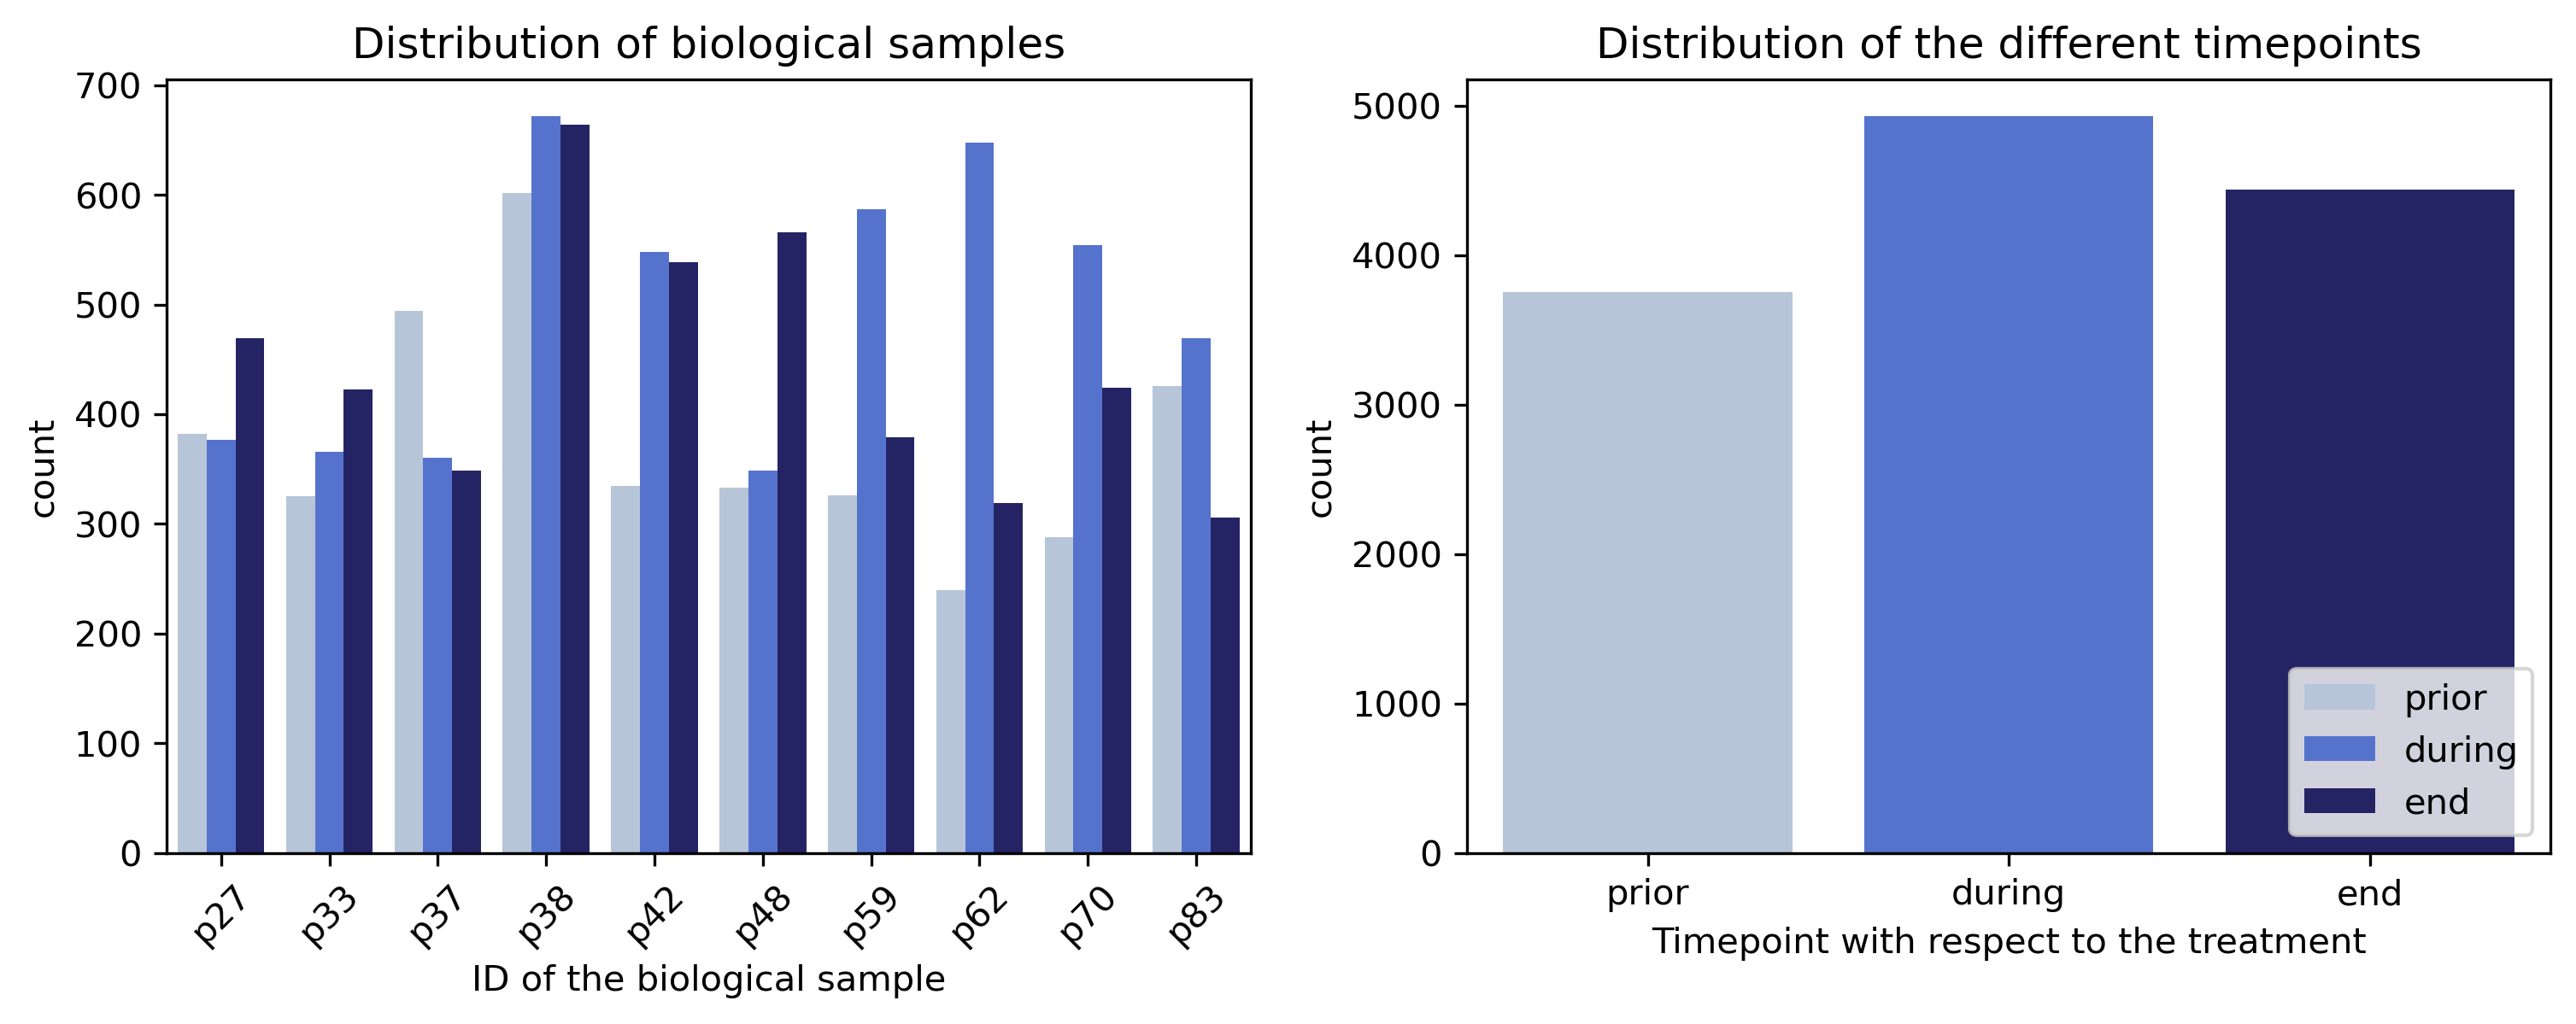

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
tp_order = ["prior", "during", "end"]
sample_order = np.unique(all_data.loc[:, "sample"])
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=all_data,
    ax=ax[0],
    order=sample_order,
    hue_order=tp_order,
    hue="timepoint",
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="timepoint",
    hue="timepoint",
    data=all_data,
    ax=ax[1],
    order=tp_order,
    dodge=False,
    palette=color_palette,
)
ax[1].set_xlabel("Timepoint with respect to the treatment")
ax[1].set_title("Distribution of the different timepoints")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

___

#### Subsampling

We next subsample the data set such that for each timepoint we have the same number of nuclei in the data set. Additionally, we ensure that the individual timepoint population are approximately uniformly represented by the different biological (patient) samples.

In [11]:
sampled_data = get_stratified_data(
    all_data, id_column="id", cond_column="timepoint", seed=1234
)

<IPython.core.display.Javascript object>

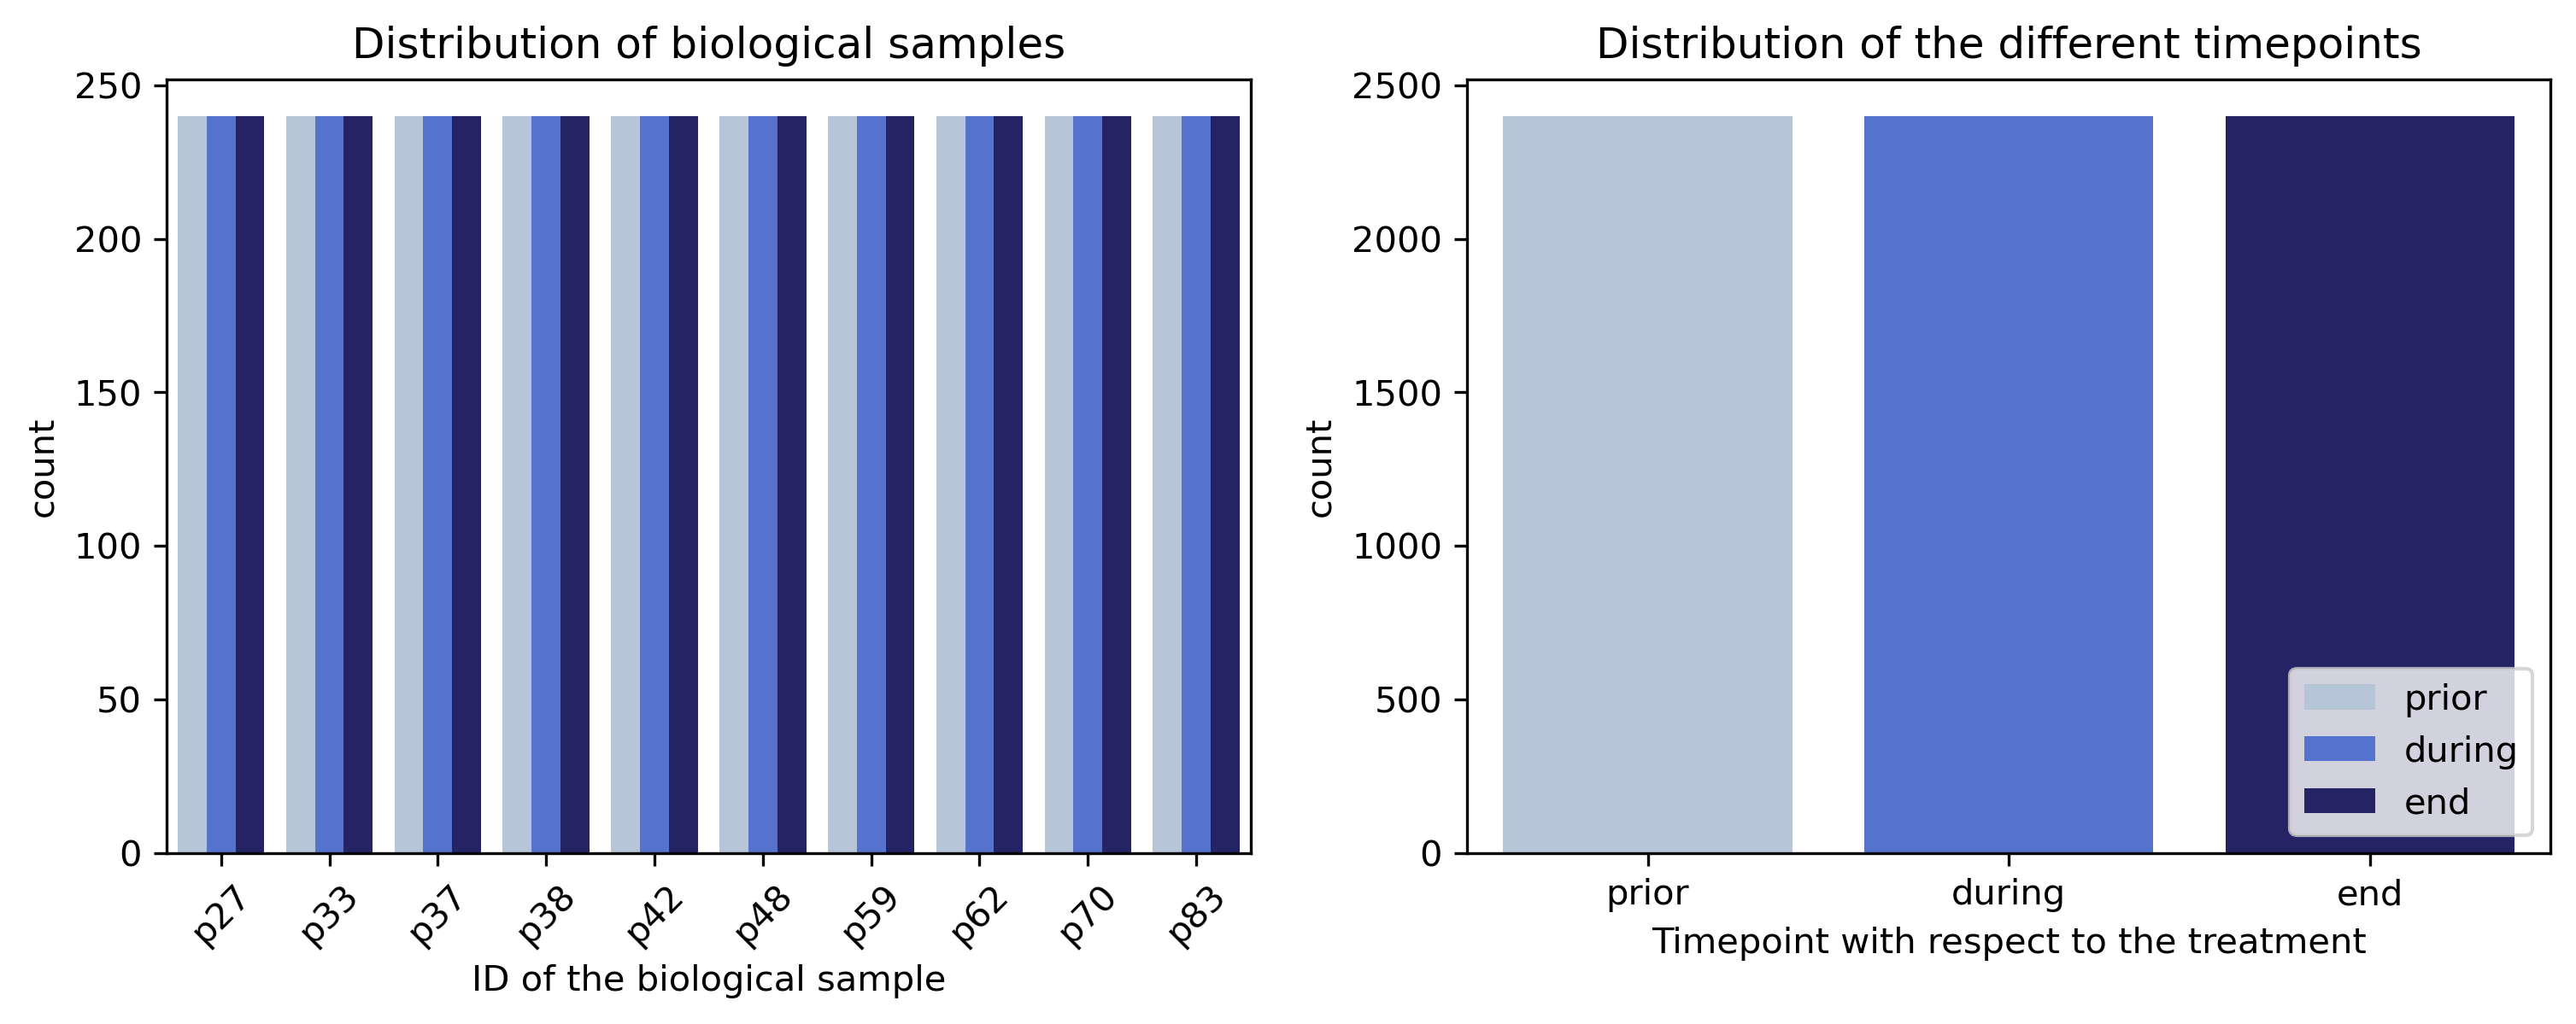

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
tp_order = ["prior", "during", "end"]
sample_order = np.unique(all_data.loc[:, "sample"])
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=sampled_data,
    ax=ax[0],
    order=sample_order,
    hue_order=tp_order,
    hue="timepoint",
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="timepoint",
    hue="timepoint",
    data=sampled_data,
    ax=ax[1],
    order=tp_order,
    hue_order=tp_order,
    dodge=False,
    palette=color_palette,
)
ax[1].set_xlabel("Timepoint with respect to the treatment")
ax[1].set_title("Distribution of the different timepoints")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

----

#### Sample and feature selection

We now filter out constant features and nuclei with missing features.

In [13]:
data = preprocess_data(sampled_data, remove_constant_features=True)

Nuclei that did not pass the quality check: 0/7200. Remaining: 7200.
Removed 7 constant or features with missing values. Remaining: 262.
Removed additional 0 features. Remaining: 262.


<IPython.core.display.Javascript object>

---

#### Data preparation

After sampling the data, we will now prepare the data for the consecutive analysis, i.e. extracting only chrometric features and corresponding metadata information.

In [14]:
all_chrometric_data = get_chrometric_data(
    data,
    proteins=["gh2ax", "lamin", "cd3"],
    exclude_dna_int=True,
)

sample_labels = data.loc[:, "sample"]
tp_labels = data.loc[:, "timepoint"]

<IPython.core.display.Javascript object>

Finally, we remove highly correlated features (Pearson $\rho > 0.8$) from the chrometric features.

In [15]:
chrometric_data = remove_correlated_features(all_chrometric_data, threshold=0.8)

Removed 133/192 features with a Pearson correlation above 0.8. Remaining: 59


<IPython.core.display.Javascript object>

---

## 3. Panels

Now we generate the individual panels for figure 3 of the paper.


### 3a. Visualization of changes of nuclear phenotypes in different cancer types

First, we provide a visual representation of the different nuclear phenotypes in health and cancer. To this end, we will randomly sample 36 nuclei from each of the three cancer types and plot a corresponding montage of the max-z projected DNA images. To visualize size differences each nuclei is padded to a size of 150x150 pixels. Note that the nuclei images were obtained from range-normalized DAPI images. The range normalization was used to mitigate batch effects.

In [16]:
image_file_path = "preprocessed/full_pipeline/segmentation/nuclei_images"
sampled_tp1_images = get_random_images(
    data.loc[data.timepoint == "prior"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)

sampled_tp2_images = get_random_images(
    data.loc[data.timepoint == "during"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)

sampled_tp3_images = get_random_images(
    data.loc[data.timepoint == "end"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
    file_name_col="file_name",
)

<IPython.core.display.Javascript object>

#### Prior treatment population

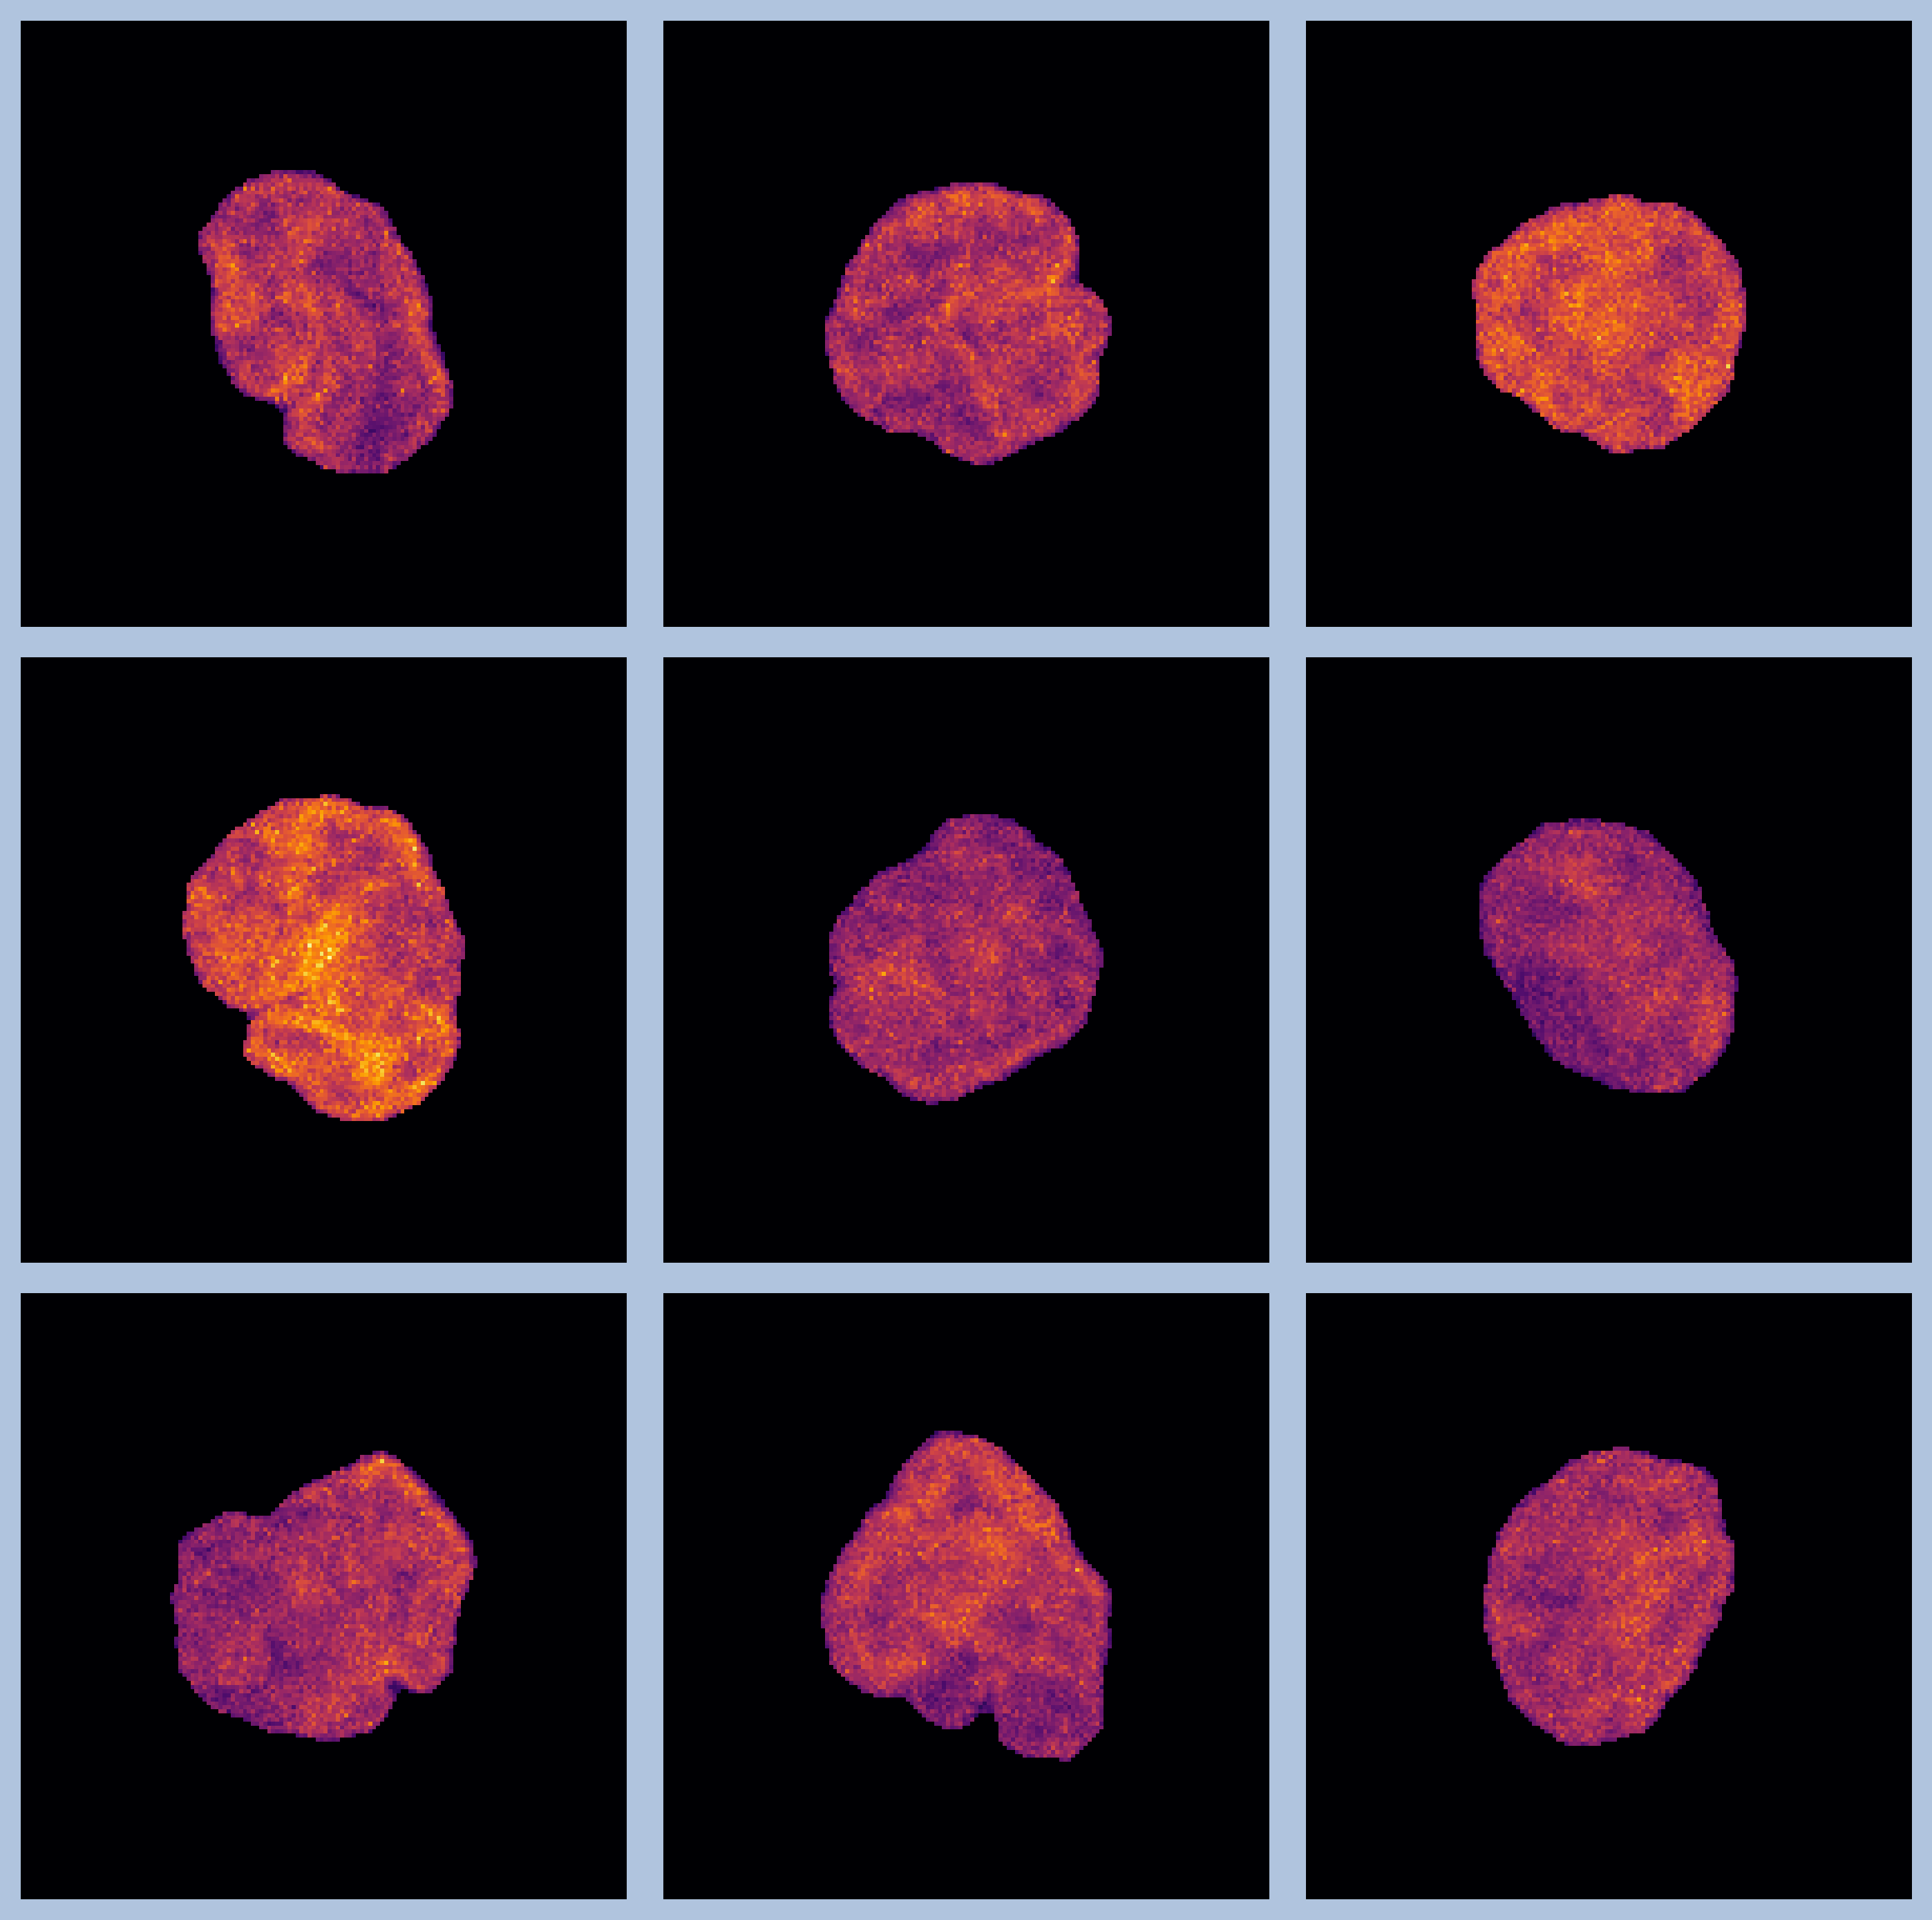

<IPython.core.display.Javascript object>

In [17]:
fig_tp1, ax_tp1 = plot_montage(
    sampled_tp1_images,
    pad_size=150,
    mask_nuclei=True,
    cmap="inferno",
    nrows=3,
    ncols=3,
)
fig_tp1.set_facecolor(color_palette["prior"])

#### During treatment population

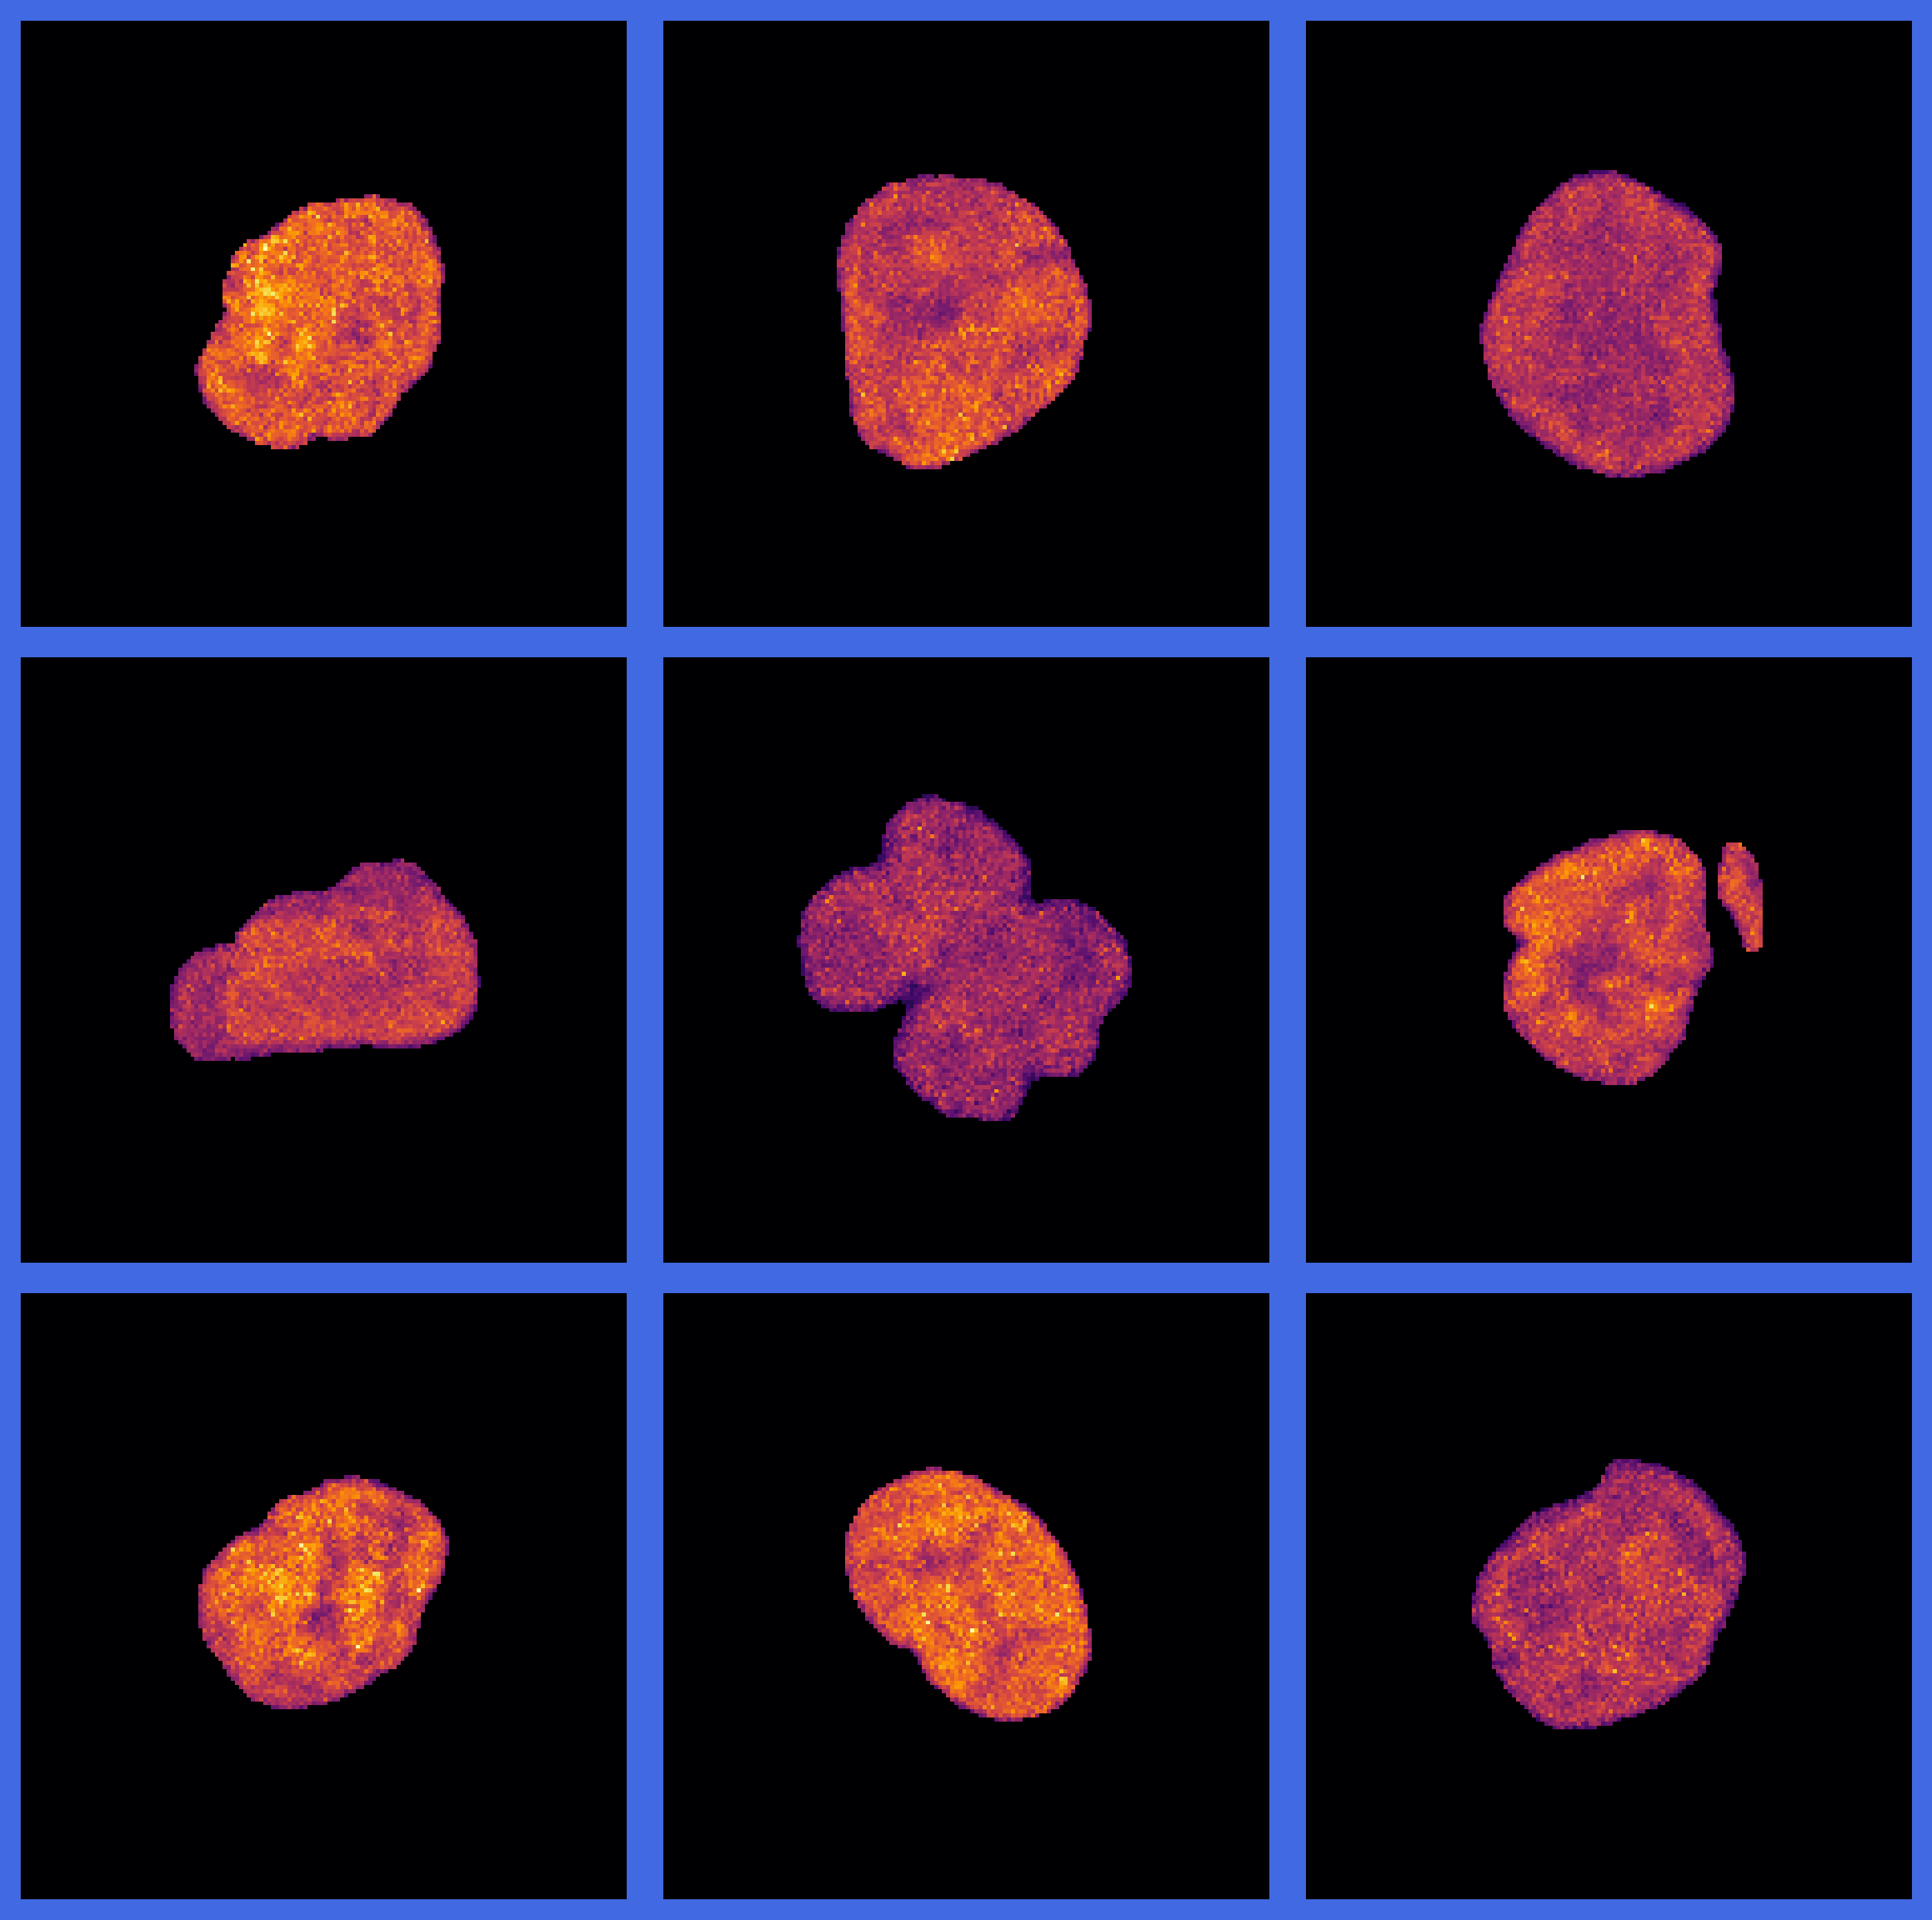

<IPython.core.display.Javascript object>

In [18]:
fig_tp2, ax_tp2 = plot_montage(
    sampled_tp2_images,
    pad_size=150,
    mask_nuclei=True,
    cmap="inferno",
    ncols=3,
    nrows=3,
)
fig_tp2.set_facecolor(color_palette["during"])

#### End of treatment population

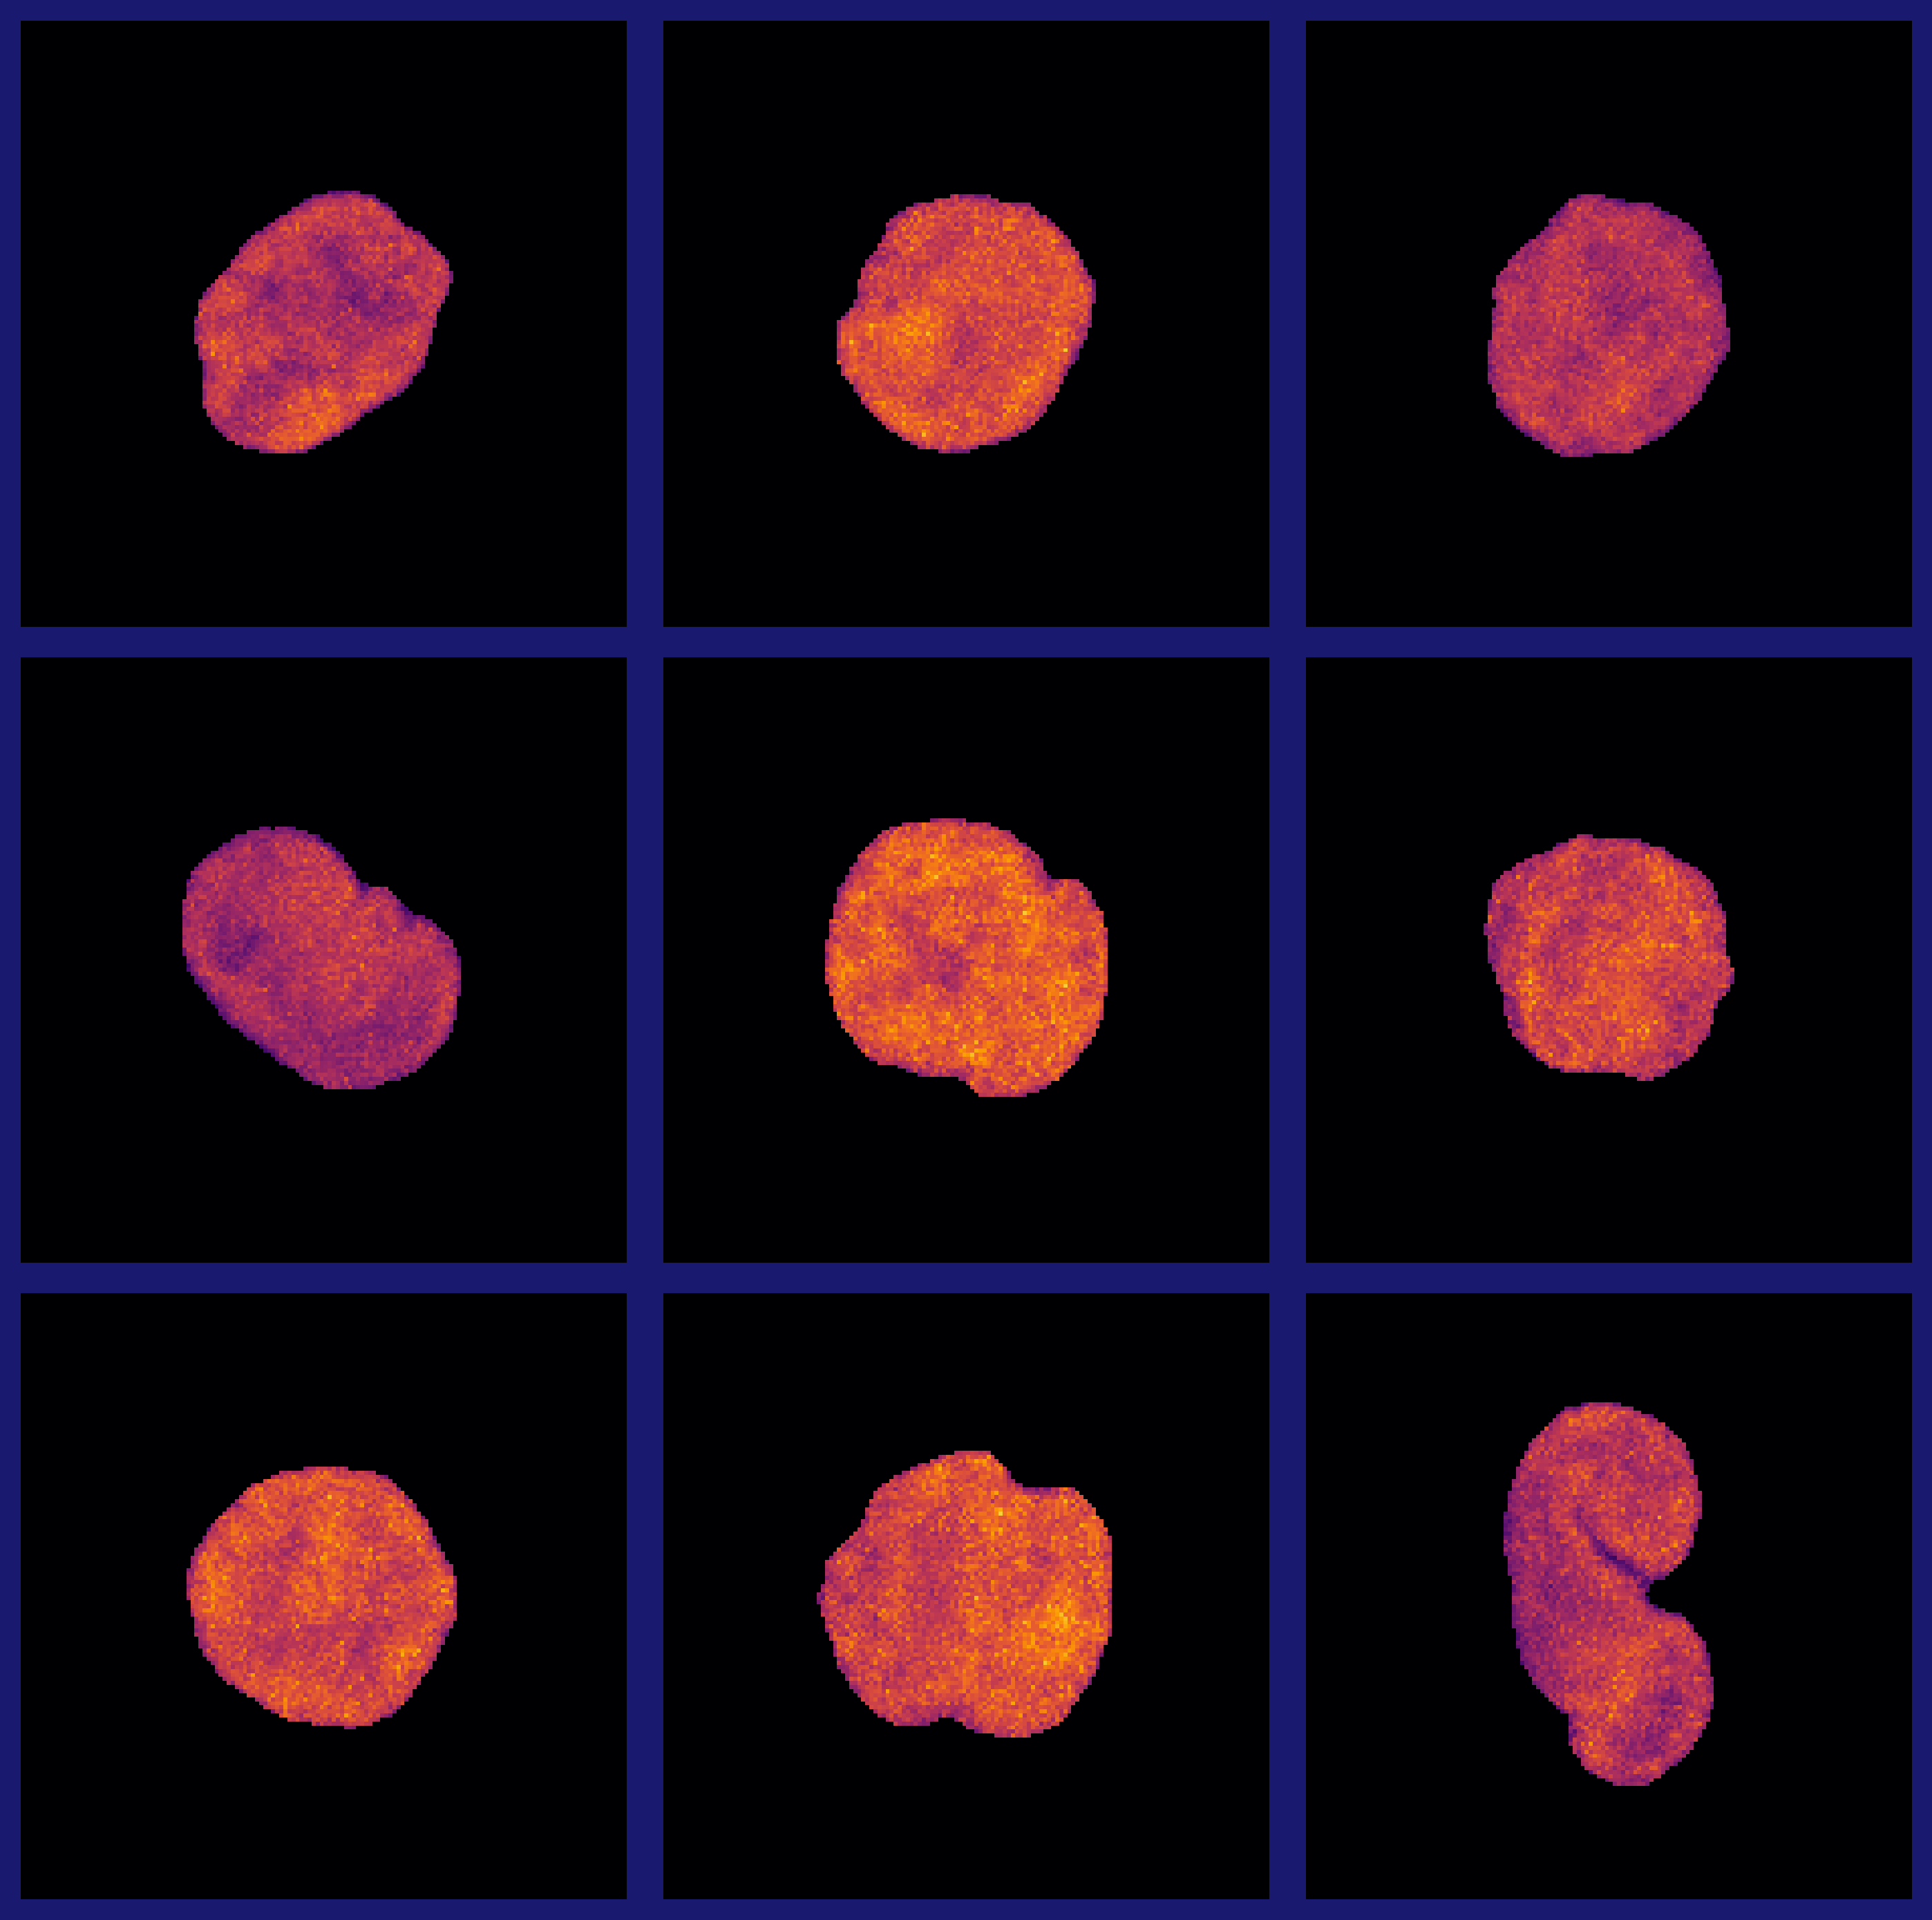

<IPython.core.display.Javascript object>

In [19]:
fig_tp3, ax_tp3 = plot_montage(
    sampled_tp3_images,
    pad_size=150,
    mask_nuclei=True,
    cmap="inferno",
    ncols=3,
    nrows=3,
)
fig_tp3.set_facecolor(color_palette["end"])

---

### 3b. Parametric analysis captures captures differences of PBMCs at different timepoints of the proton therapy treatment

The montage already indicate significant changes in particular between the chrometric pheontype of the PBMCs prior the treatment and the end of it. We will now turn to the assessment of the parametric descriptions of the nuclear phenotypes of the PBMCs at those different timepoints. To this end, we first visualize the data set using a tSNE plot to assess potential large-scale differences between the timepoint populations and individual patient samples.

In [20]:
chrometric_embs = get_tsne_embs(chrometric_data)
chrometric_embs["timepoint"] = np.array(tp_labels)
chrometric_embs["sample"] = np.array(sample_labels)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

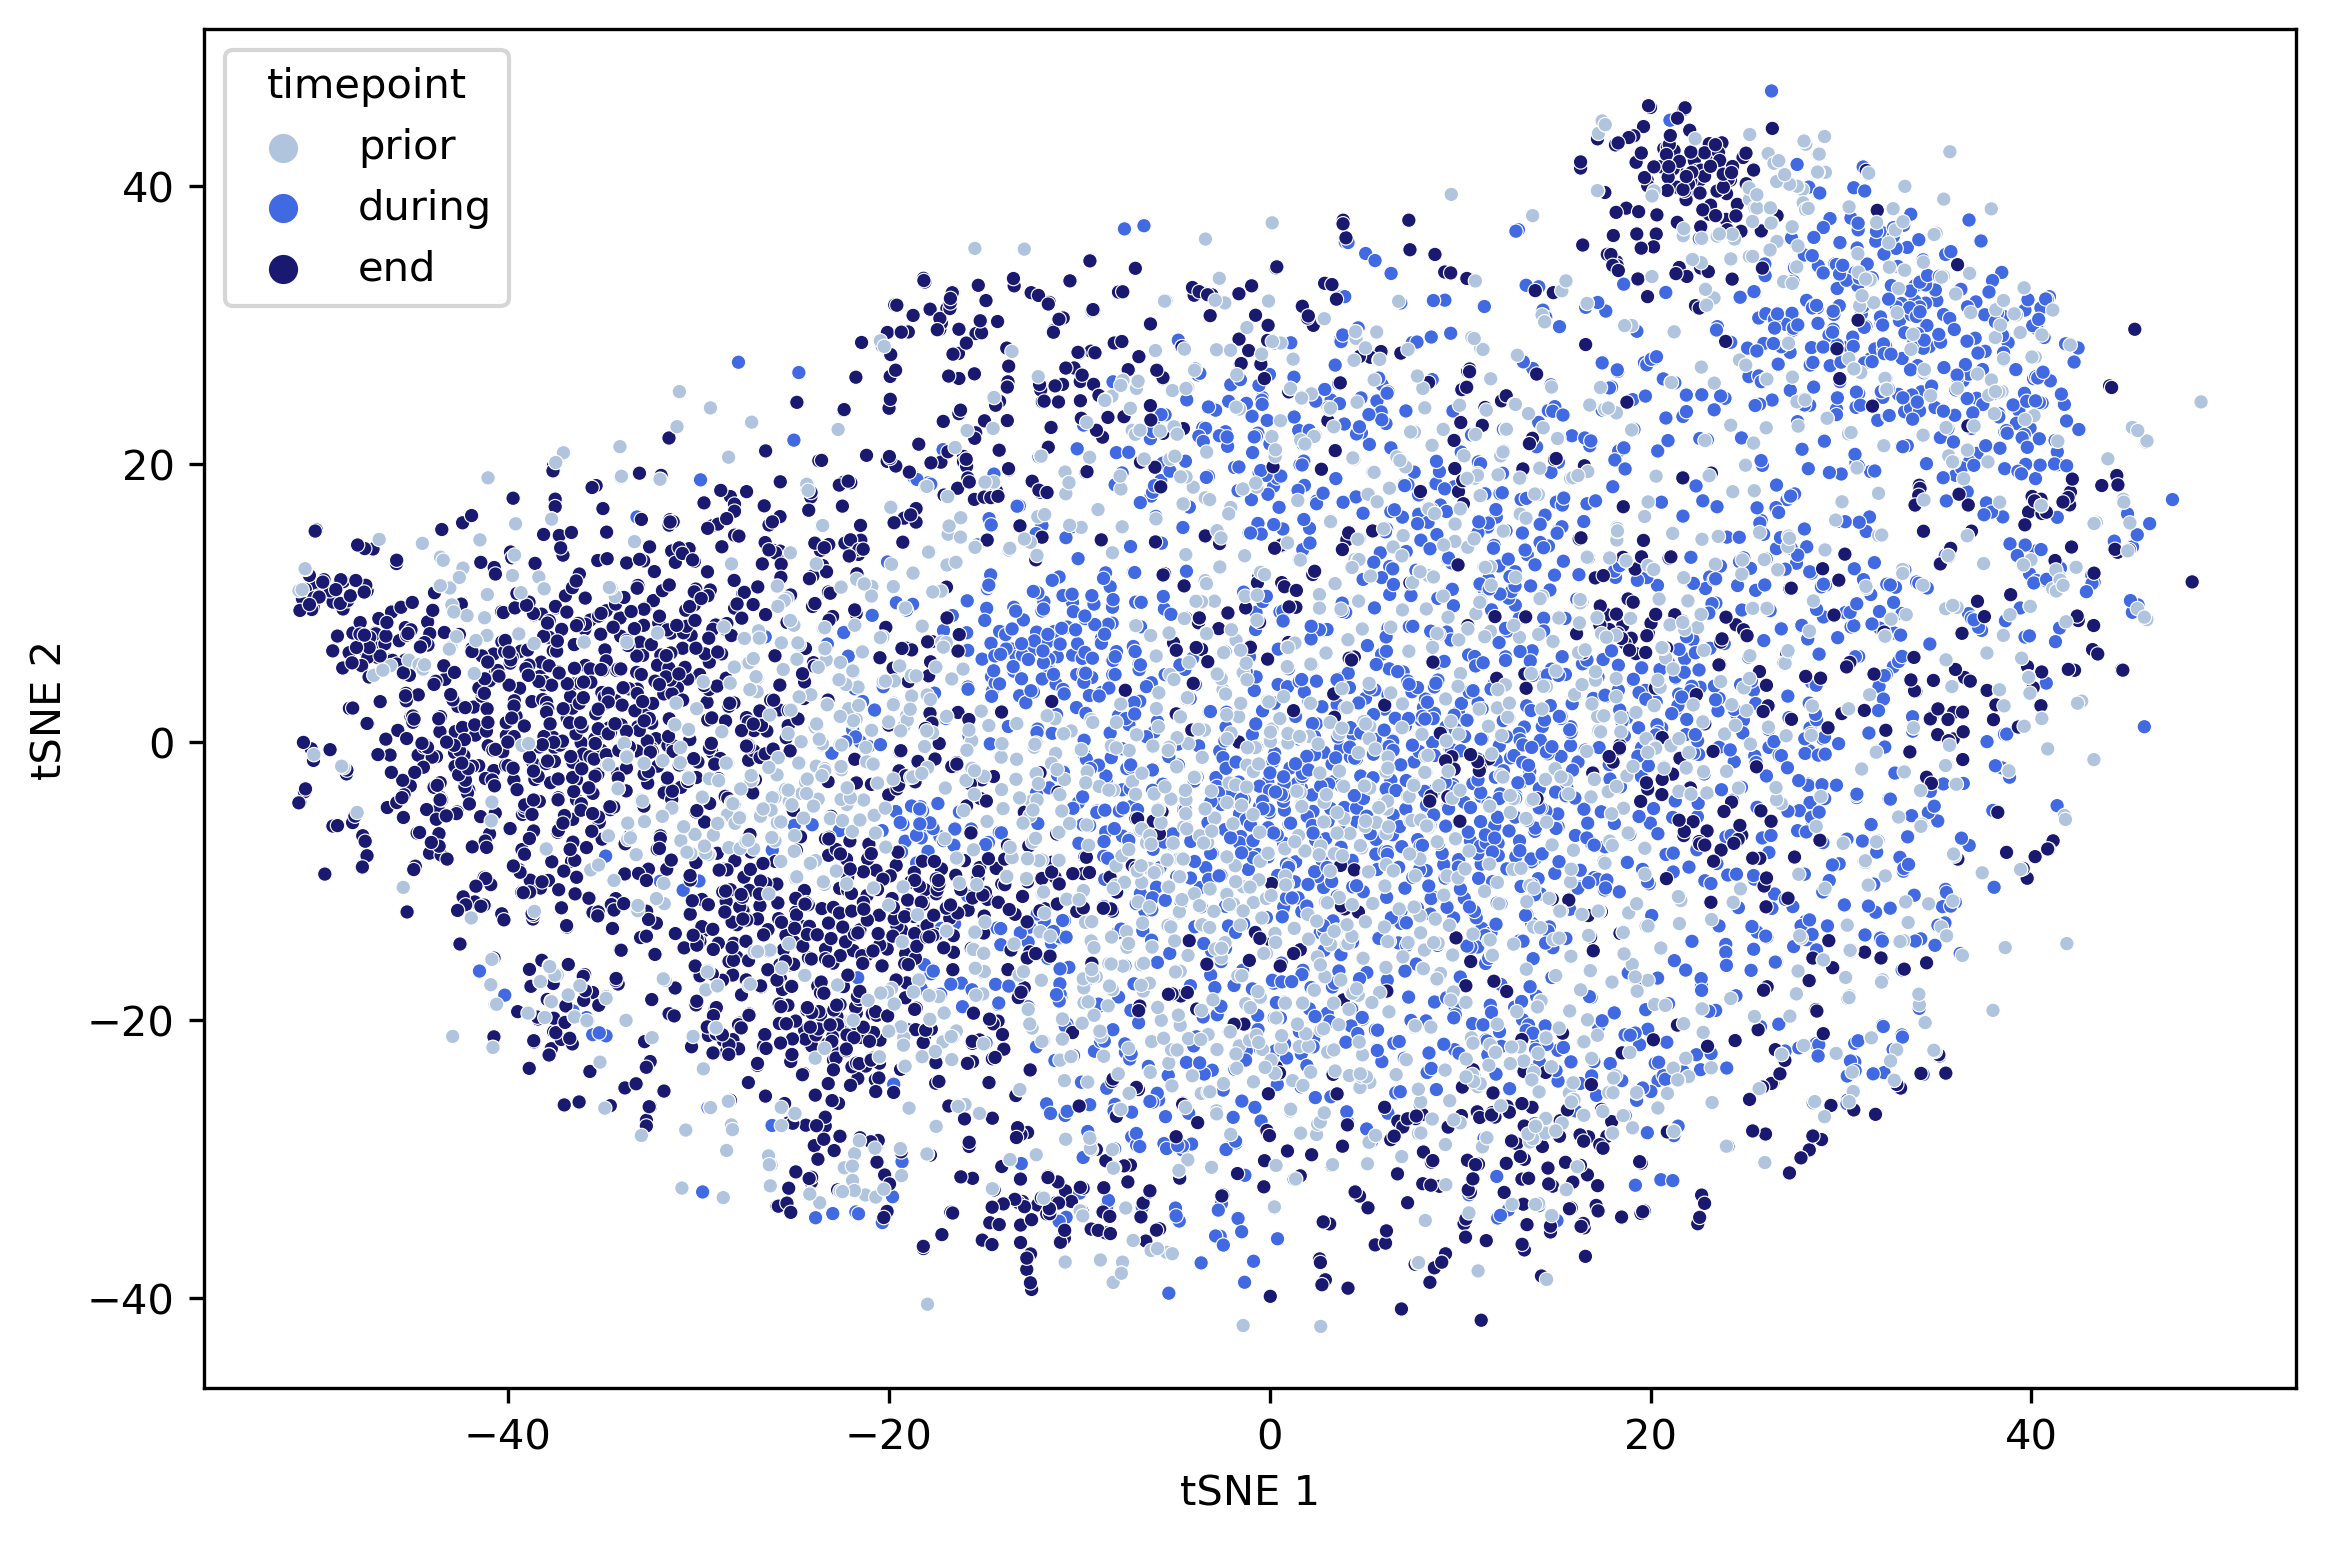

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="timepoint",
    hue_order=tp_order,
    ax=ax,
    s=12,
    marker="o",
    palette=color_palette,
)
plt.show()

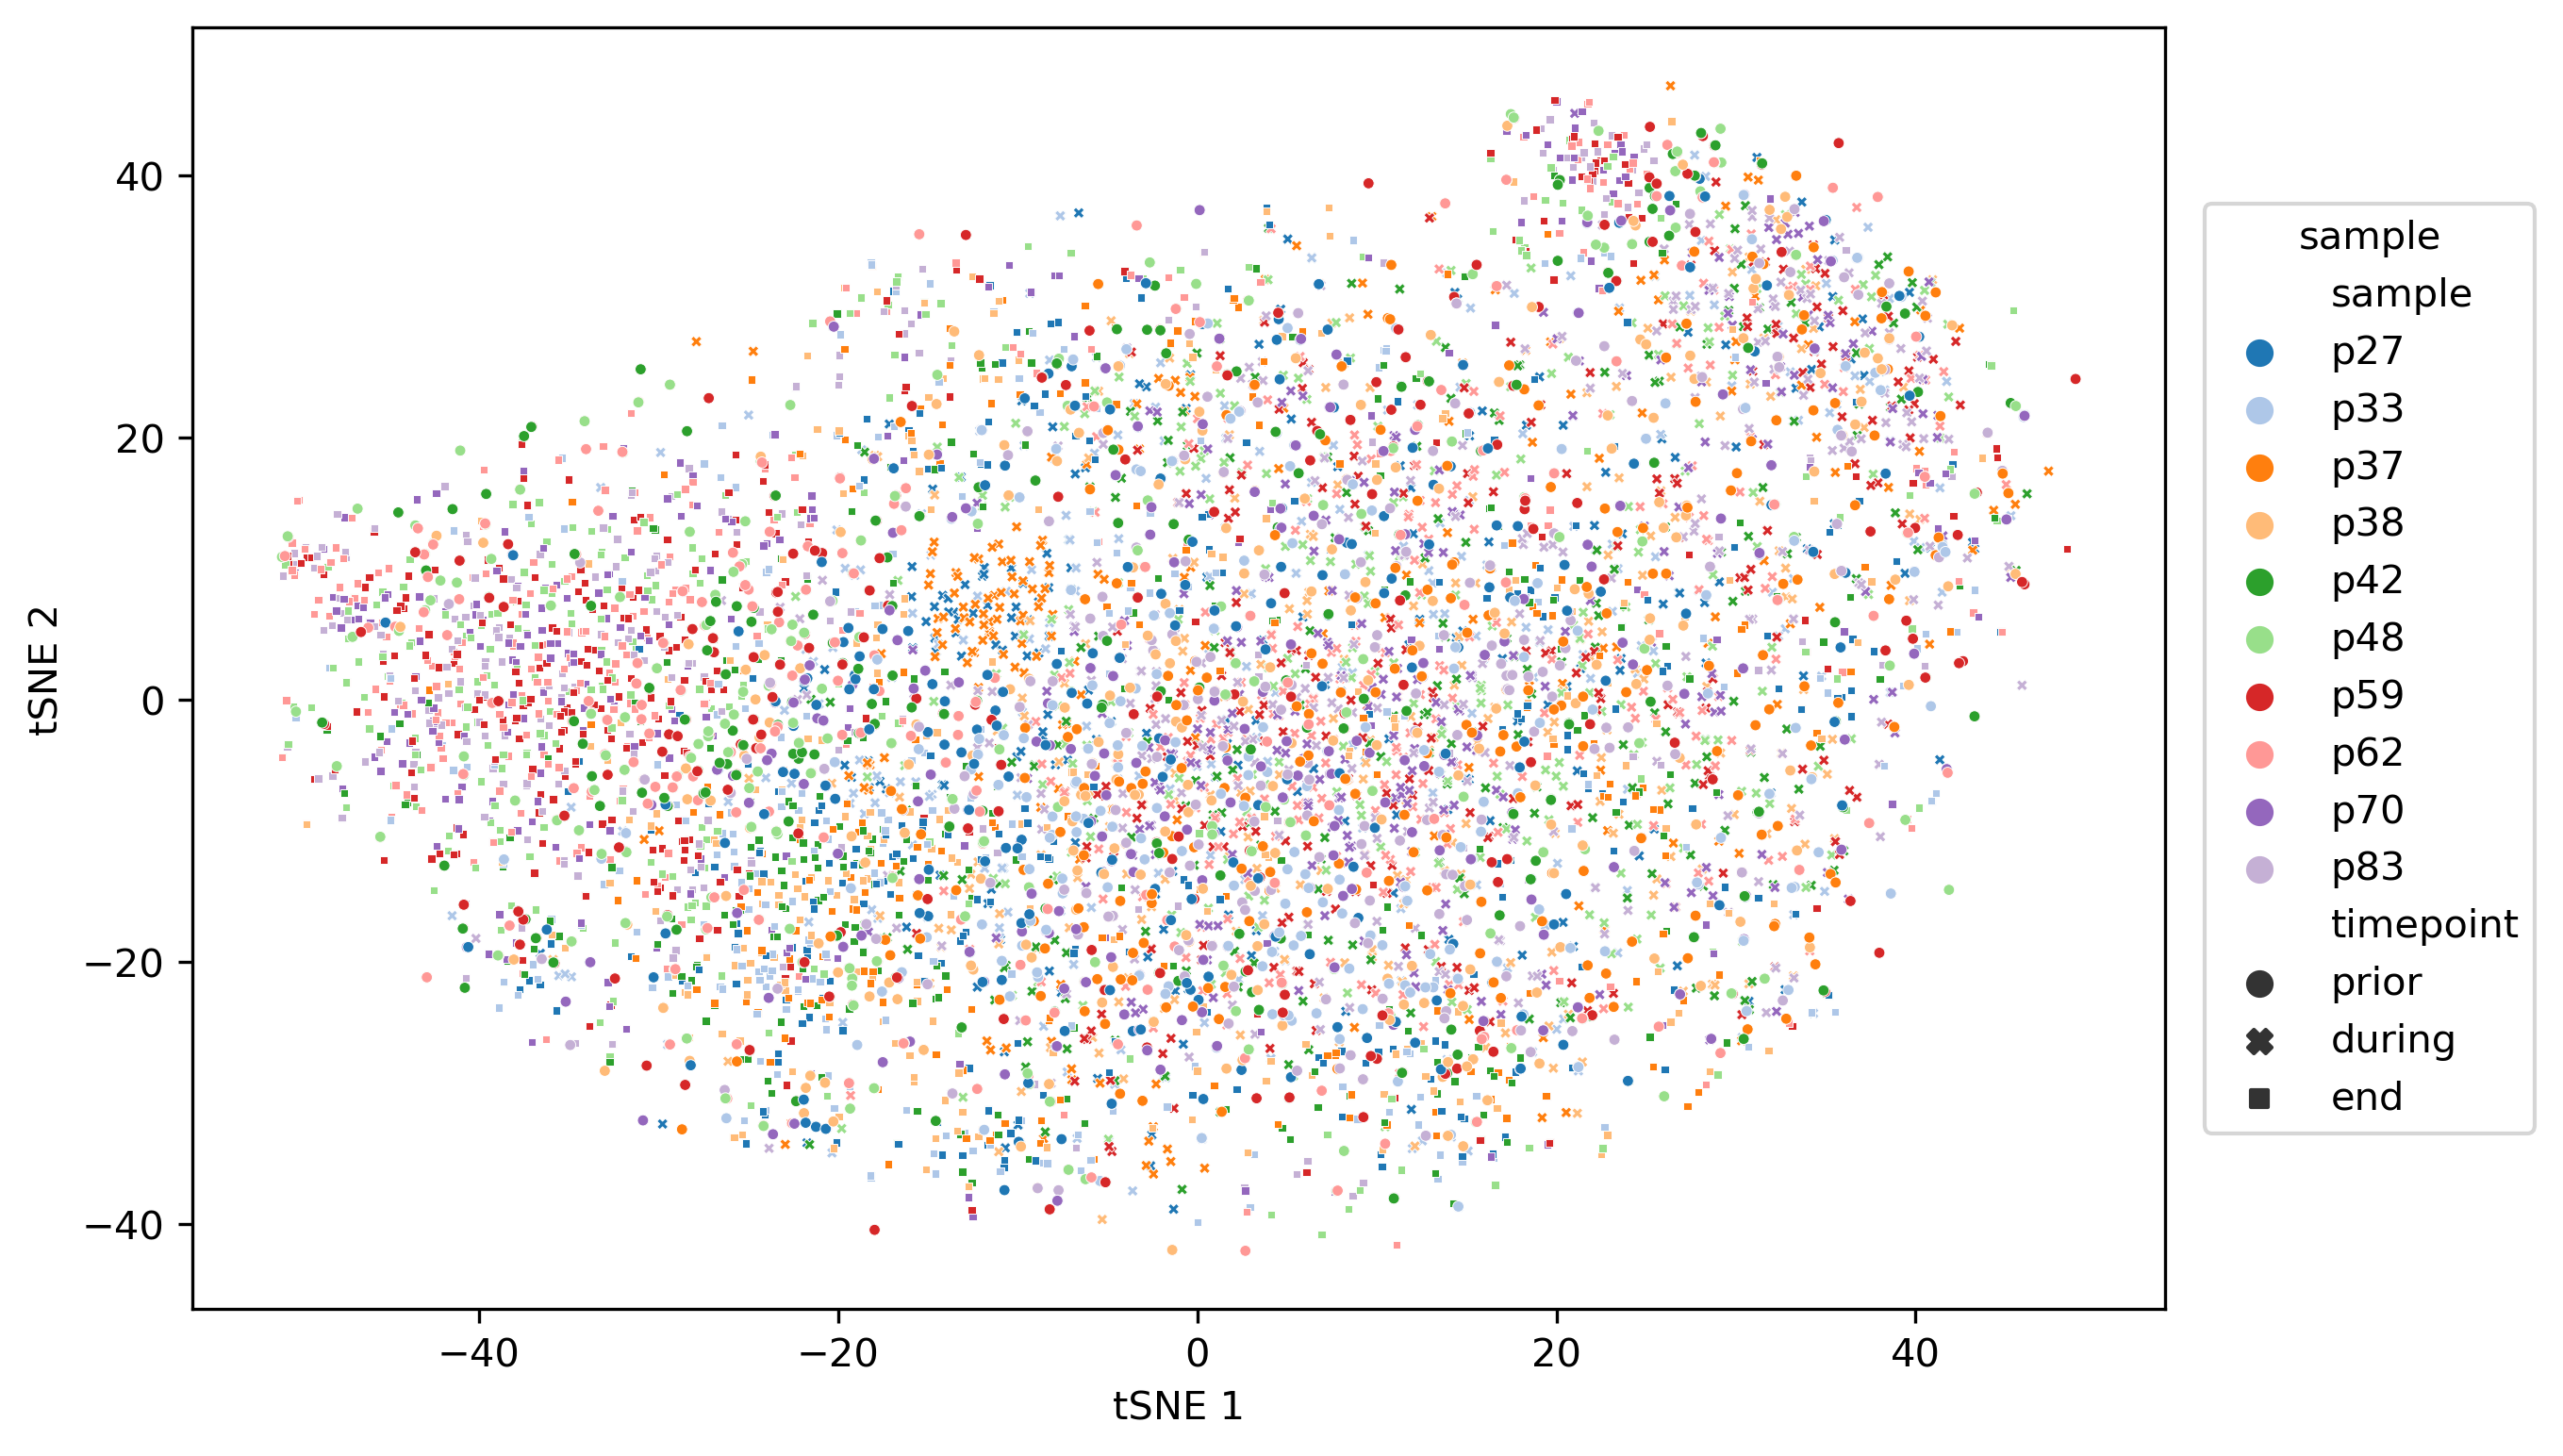

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="sample",
    style="timepoint",
    style_order=tp_order,
    hue_order=sample_order,
    ax=ax,
    s=8,
    marker="o",
    palette="tab20",
)
plt.legend(
    bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0, title="sample"
)
plt.show()

The tSNE plot also shows that especially the chrometric phenotypes of the PBMCs at the end of the proton therapy look different from the prior and during treatment population. This suggest the resemblance of the delayed treatment effect in the chrometric configuration of the PBMCs of Meningioma patients.

The patient samples are fairly well mixed with probably the small exception of the PBMCs of P48 taken at the end of the proton therapy.

---

#### Classification of the different cancer types.

To quantify the separability of the timepoint populations using the chrometric phenotypes of the PBMCs of the different cancer patients we perform a 10-fold stratified cross-validation analysis using a RandomForest classifier. The classifier provides a simple non-linear classification model which also yields an importance measure for the individual chrometric features indicating which ones are most different between the three populations.

##### Nuclei split

At first we will split the data randomly on a nuclei-basis, i.e. nuclei of the same patient will be likely included in both the training and the test sets.

In [23]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)

<IPython.core.display.Javascript object>

In [24]:
tp_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=rfc,
    features=chrometric_data,
    labels=tp_labels,
    scale_features=False,
    n_folds=10,
    order=tp_order,
)
normalized_cv_conf_mtx_nuclei = tp_cv_conf_mtx_nuclei.divide(
    tp_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

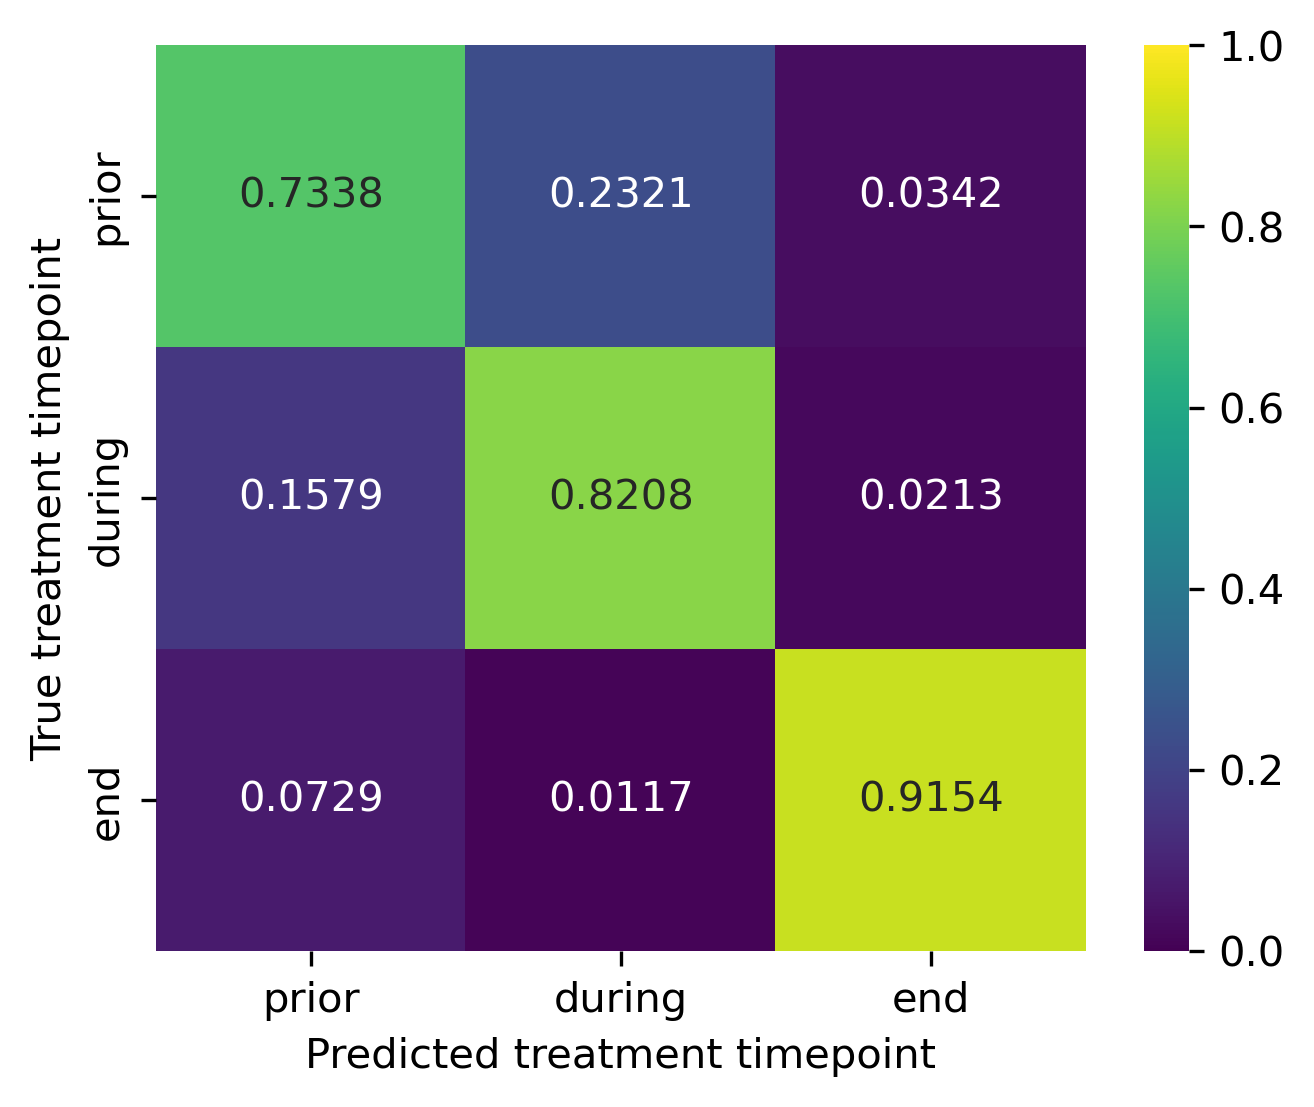

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted treatment timepoint")
ax.set_ylabel("True treatment timepoint")
plt.show()

The classifier is able to accurately distinguish nuclei from the timepoint populations. The confusion matrix also shows that the classifier does particularly better on distinguishing PBMCs from the end of the treatment from the other two timepoints, where those are more often confused for one another. This again suggests a greater similarity of the chrometric phenotype of PBMCs prior and during the proton therapy treatment and thus a delayed treatment effect. However, one should note that those changes could also be confounded by the effect of the recovery of the patients from preceeding treatments.

To further assess the similarity of the different timepoint distribution and their linear separability we use a linear discriminant analysis.

In [26]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda_tp_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=lda,
    features=chrometric_data,
    labels=tp_labels,
    scale_features=True,
    n_folds=10,
    order=tp_order,
)
lda_normalized_cv_conf_mtx_nuclei = lda_tp_cv_conf_mtx_nuclei.divide(
    lda_tp_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

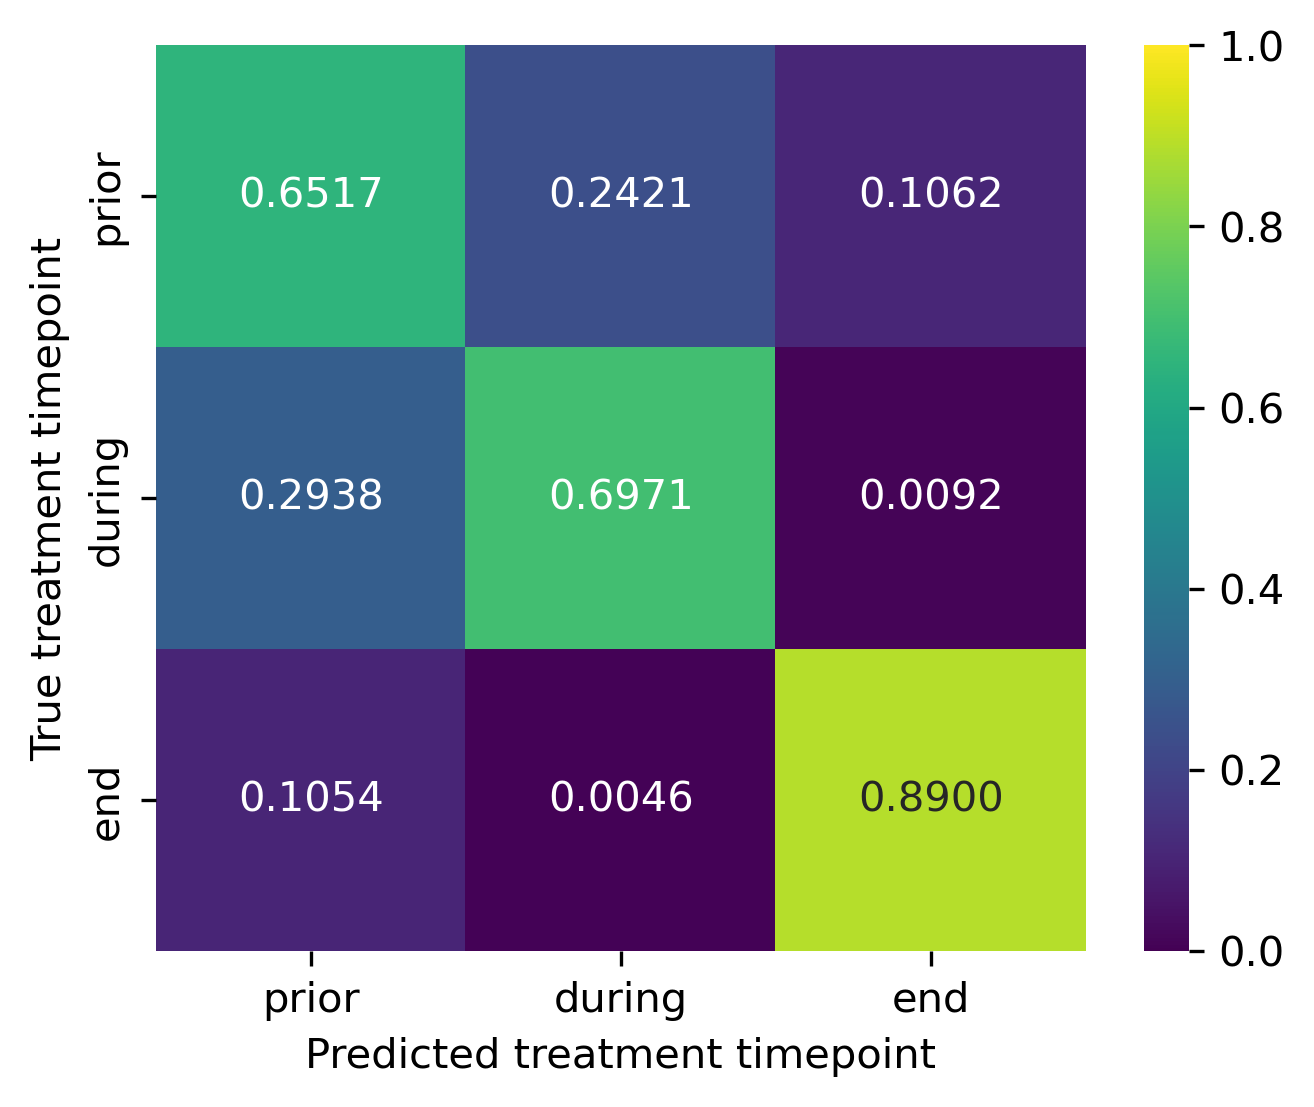

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    lda_normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted treatment timepoint")
ax.set_ylabel("True treatment timepoint")
plt.show()

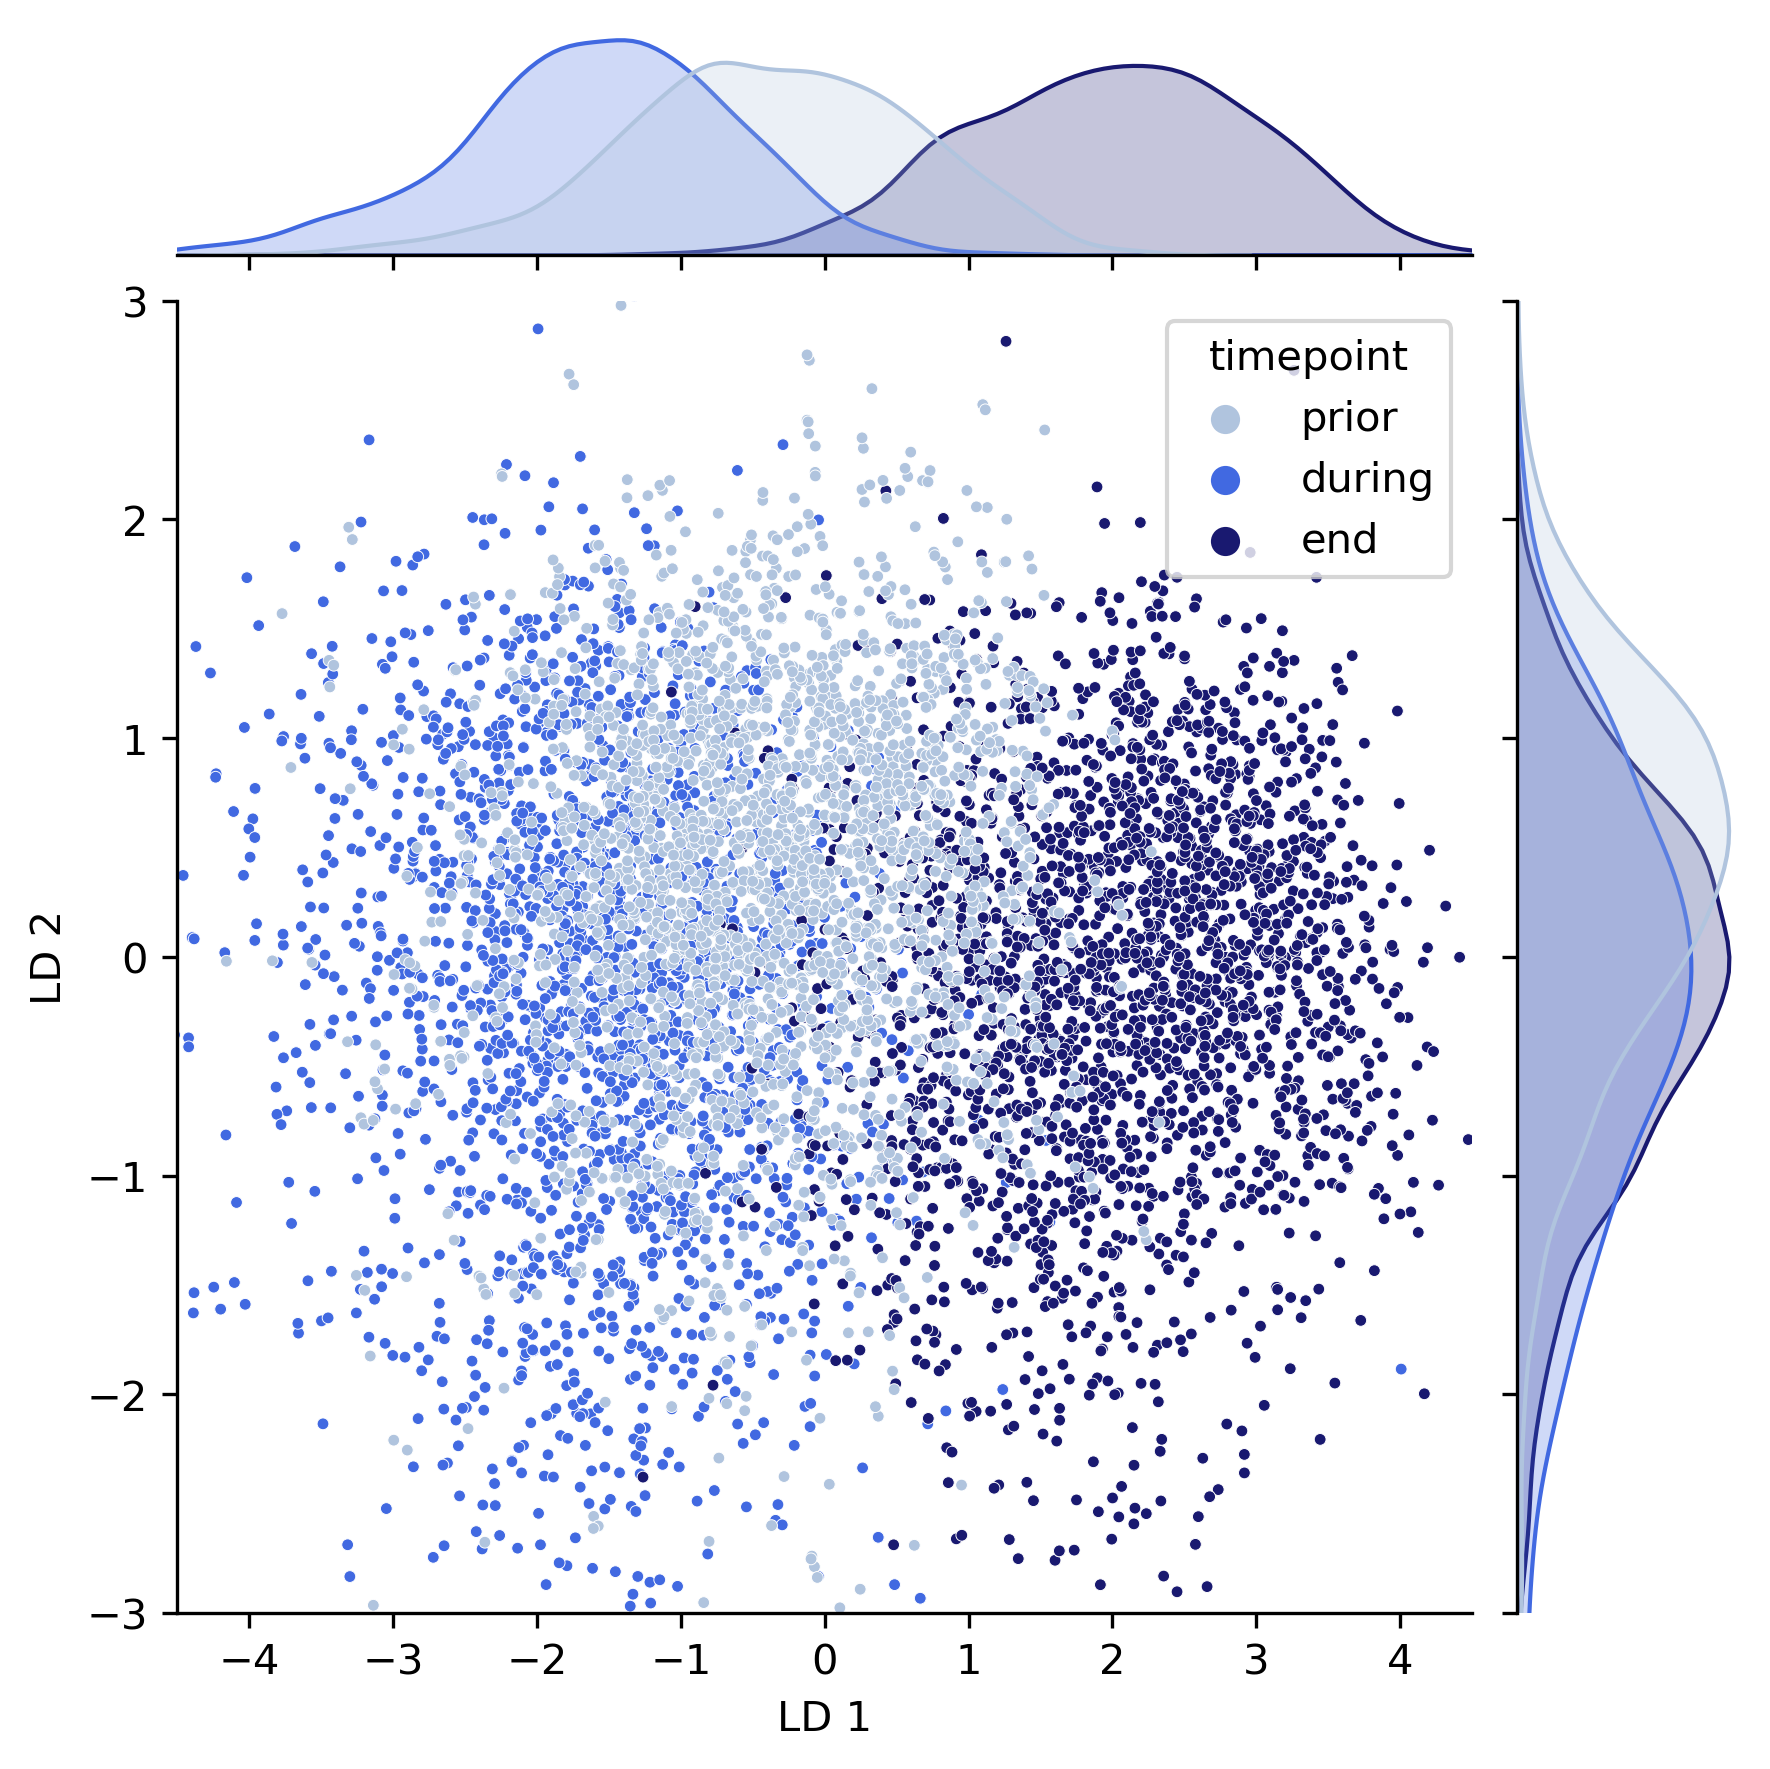

<IPython.core.display.Javascript object>

In [45]:
lda_transformed = pd.DataFrame(
    lda.fit(chrometric_data, tp_labels).transform(chrometric_data),
    columns=["LD 1", "LD 2"],
    index=chrometric_data.index,
)
lda_transformed["timepoint"] = np.array(tp_labels)
lda_transformed["sample"] = np.array(sample_labels)
g = sns.jointplot(
    data=lda_transformed,
    x="LD 1",
    y="LD 2",
    hue="timepoint",
    s=8,
    hue_order=tp_order,
    height=6,
    palette=color_palette,
    xlim=[-4.5, 4.5],
    ylim=[-3, 3],
)

In [29]:
np.sum(np.abs(lda_transformed.loc[:, "LD 1"]) > 4.5) + np.sum(
    np.abs(lda_transformed.loc[:, "LD 2"]) > 3
)

98

<IPython.core.display.Javascript object>

The above LDA plot suggests in addition to the confusion matrix that the indeed the population of the PBMCs prior and during the treatment of the proton therapy look more alike compared to those at the end of the treatment. However, we interestingly see that the end of treatment population seems to be slighlty more similar to that prior the treatment than to the one during the treatment.

Note that in the above plot one outlier sample is excluded for better visualization of the population differences.

---
#### Patient split


While the previous analysis assess the level of differences of the chrometric phenotypes of the PBMCs between the different treatment timepoints, the classifier can make use of patient specific characteristics during the classification. In a diagnostic use case such information would not be available. To evaluate how well a classifier would be able to predict for unseen patient the corresponding treatment timepoint simply based on the chrometric phenotypes of the PBMCs, we also assess the class separability using a stratified 5-fold patient-cross-validation approach. Thereby at each iteration 1-2 of the patients of each timepoint are hold out for the test set.

In [30]:
tp_cv_conf_mtx_patient = get_cv_conf_mtx(
    estimator=rfc,
    features=chrometric_data,
    labels=tp_labels,
    groups=sample_labels,
    scale_features=False,
    n_folds=5,
    order=tp_order,
)
normalized_cv_conf_mtx_patient = tp_cv_conf_mtx_patient.divide(
    tp_cv_conf_mtx_patient.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

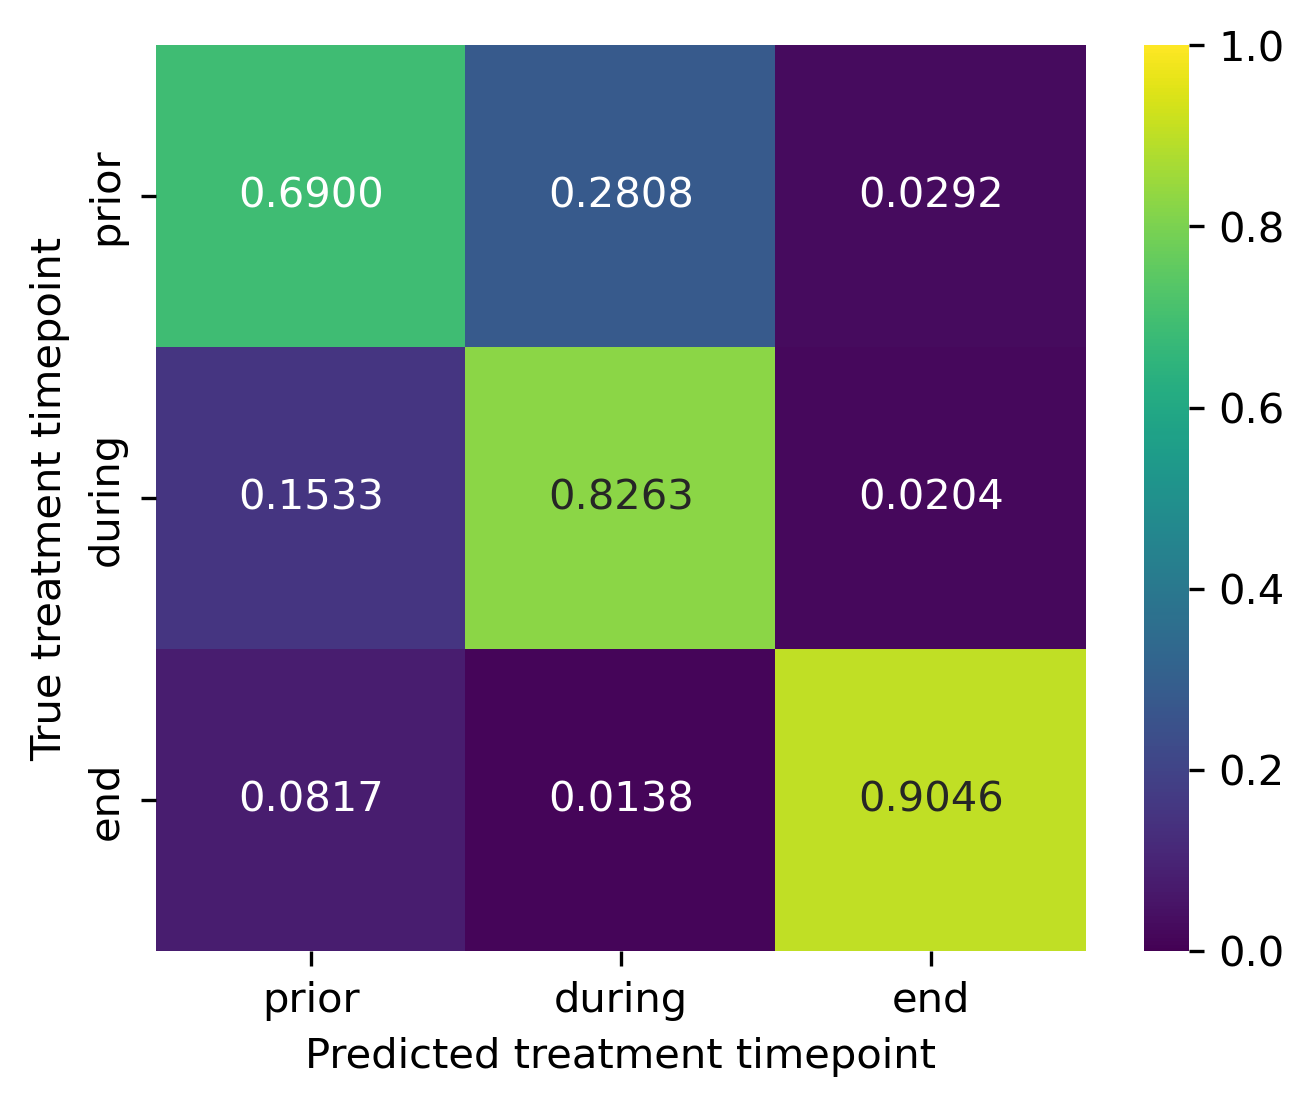

<IPython.core.display.Javascript object>

In [31]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_cv_conf_mtx_patient,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted treatment timepoint")
ax.set_ylabel("True treatment timepoint")
plt.show()

In [32]:
groupkfold = StratifiedGroupKFold(n_splits=10)
cv_bacs = cross_val_score(
    rfc,
    cv=groupkfold,
    X=chrometric_data,
    y=tp_labels,
    groups=sample_labels,
    scoring="balanced_accuracy",
    n_jobs=10,
)
print("Balanced accuracy: {} (+/- {})".format(np.mean(cv_bacs), np.std(cv_bacs)))

Balanced accuracy: 0.818888888888889 (+/- 0.09018627841758865)


<IPython.core.display.Javascript object>

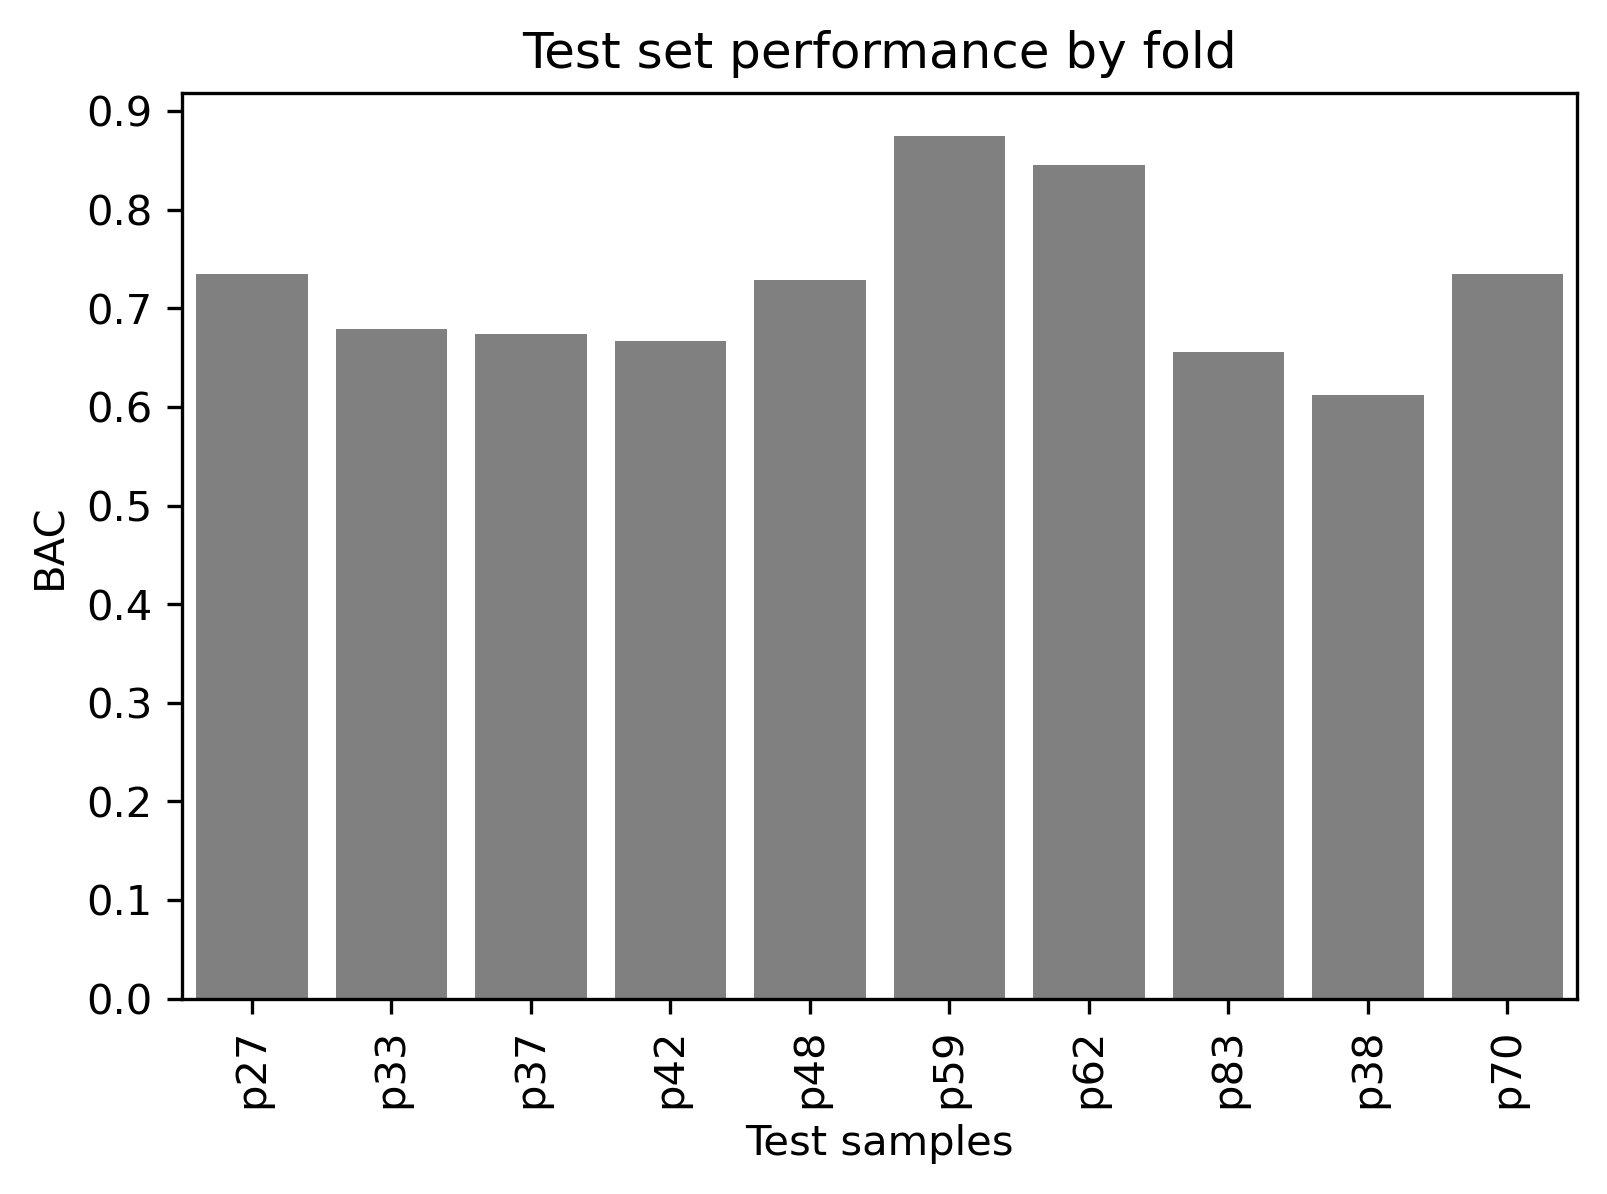

<IPython.core.display.Javascript object>

In [48]:
test_samples = []
for train_idx, test_idx in groupkfold.split(chrometric_data, tp_labels, sample_labels):
    test_samples.append("_".join(np.unique(sample_labels[test_idx])))
cv_bac_df = pd.DataFrame(cv_bacs, columns=["BAC"])
cv_bac_df["Test samples"] = test_samples
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.barplot(x="Test samples", y="BAC", data=cv_bac_df, palette=["gray"], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Test set performance by fold")
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

In [46]:
cv_bacs = cross_val_score(
    lda,
    cv=groupkfold,
    X=chrometric_data,
    y=tp_labels,
    groups=sample_labels,
    scoring="balanced_accuracy",
    n_jobs=10,
)
print("Balanced accuracy: {} (+/- {})".format(np.mean(cv_bacs), np.std(cv_bacs)))

Balanced accuracy: 0.7206944444444444 (+/- 0.07921161004970587)


<IPython.core.display.Javascript object>

In general the confusion matrix again shows a similar picture as seen for the nuclei-based split showing that end of treatment population show phenotypes of the PBMCs significantly different from the other two treatment timepoints.

---

### 3c. Nuclear chromatin biomarkers identifying cancer populations

#### Feature importance

We have validated that there are significant differences between the individual treatment timepoints in particular when comparing PBMCs at the end of the treatment with those of during respectively prior the treatment. We next assess the implicit feature importance of a RandomForest classifier trained on the task to distinguish between the timepoint populations types in order to get an idea of the features are most indicative for the treatment effect.

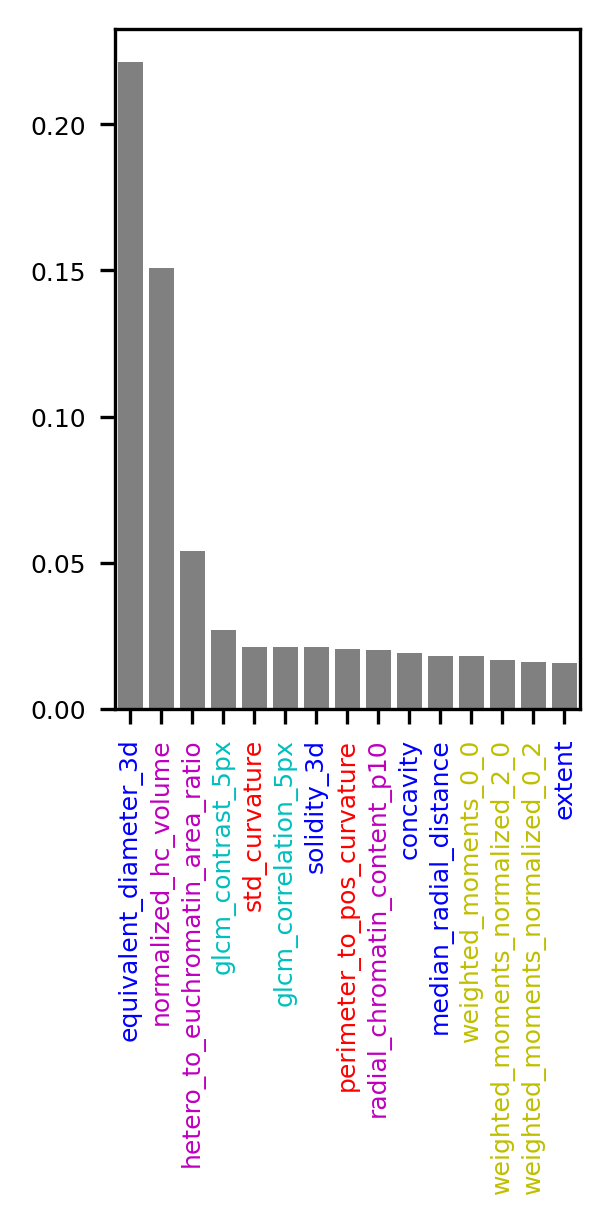

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plot_feature_importance_for_estimator(
    rfc,
    chrometric_data,
    tp_labels,
    scale_features=False,
    feature_color_dict=feature_color_dict,
    n_features=15,
    cmap=["gray"],
    figsize=[2, 3],
)

The analysis suggests that the features that changes the most between the individual treatment populations is the size of the nucleus as well as the heterochromatin content, the texture describing the chromatin organizations as well as the shape of the overall DNA intensity distribution inside the nucleus in 2D.

The previously shown feature importance plots already suggest a number of candidate chrometric biomarkers that capture the differences of the nuclear phenotypes of the PBMCs during the treatment. We now run marker screen by testing for differential distributions of the individual chrometric features between the different treatment timepoint populations. To this end, we apply a t-test to test for difference in the means and adjust for multiple testing using the Benjamini-Hochberg procedure.

In [34]:
marker_screen_results = find_markers(chrometric_data, tp_labels)

Run marker screen:   0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

#### Prior treatment

At first we look at the features whose mean is significantly different prior the proton therapry treatment compared to during respectively the end of it.

In [35]:
marker_screen_results.loc[marker_screen_results.label == "prior"].head(10)

label                            marker        fc  abs_delta_fc  \
54  prior            equivalent_diameter_3d  1.021071      0.021071   
17  prior                 glcm_contrast_5px  0.919871      0.080129   
57  prior              normalized_hc_volume  1.027555      0.027555   
22  prior              weighted_moments_0_0  0.956810      0.043190   
16  prior  hetero_to_euchromatin_area_ratio  1.041464      0.041464   
56  prior                       solidity_3d  1.010383      0.010383   
11  prior              median_neg_curvature  0.956748      0.043252   
7   prior                     std_curvature  0.962039      0.037961   
23  prior   weighted_moments_normalized_0_2  1.050503      0.050503   
20  prior              glcm_correlation_5px  0.988182      0.011818   

            pval   pval_adjust  
54  1.314903e-69  1.292988e-68  
17  1.377387e-34  7.864436e-34  
57  2.098391e-33  1.160672e-32  
22  1.481625e-19  5.701036e-19  
16  2.688606e-19  1.012517e-18  
56  6.711707e-14  2.375944e-13  
11  3.643718e-11  1.264584e-10  
7   1.120056e-10  3.740564e-10  
23  6.076779e-10  1.955618e-09  
20  1.245858e-09  3.868718e-09

<IPython.core.display.Javascript object>

We find that the PBMCs prior the treatment are average slightly larger, the projected DNA image shows higher contrast within the nucleus and a larger number of polarity changes of the nuclear boundary.

---

#### During treatment

Next we look at the features whose mean is significantly different in the during treatment population.

In [36]:
marker_screen_results.loc[marker_screen_results.label == "during"].head(10)

label                            marker        fc  abs_delta_fc  \
16  during  hetero_to_euchromatin_area_ratio  1.190578      0.190578   
57  during              normalized_hc_volume  1.133525      0.133525   
54  during            equivalent_diameter_3d  1.064812      0.064812   
7   during                     std_curvature  1.153231      0.153231   
14  during        perimeter_to_pos_curvature  0.967073      0.032927   
13  during       num_prominant_neg_curvature  1.200677      0.200677   
12  during       num_prominant_pos_curvature  1.163414      0.163414   
55  during                            extent  0.950103      0.049897   
9   during                 max_pos_curvature  1.125304      0.125304   
58  during      radial_chromatin_content_p10  0.642196      0.357804   

             pval    pval_adjust  
16   0.000000e+00   0.000000e+00  
57   0.000000e+00   0.000000e+00  
54   0.000000e+00   0.000000e+00  
7   7.256874e-131  1.605583e-129  
14  6.408766e-106  1.134352e-104  
13   1.255125e-94   1.851309e-93  
12   7.835307e-92   1.066807e-90  
55   1.943219e-72   2.023234e-71  
9    3.095177e-65   2.608792e-64  
58   7.185614e-61   5.529799e-60

<IPython.core.display.Javascript object>

The during treamtent population seems to feature PBMCs that are slightly larger and have a significantly larger heterochromatin content. Additionally, the skewness and kurtosis of the DNA distribution of the projected DNA image is reduced.

---

#### End of treatment

Finally, we also evaluate the chrometric phenotype of PBMCs at the end of the proton therapy treatment.

In [37]:
marker_screen_results.loc[marker_screen_results.label == "end"].head(10)

label                            marker        fc  abs_delta_fc  \
57   end              normalized_hc_volume  0.852489      0.147511   
16   end  hetero_to_euchromatin_area_ratio  0.794950      0.205050   
54   end            equivalent_diameter_3d  0.917942      0.082058   
14   end        perimeter_to_pos_curvature  1.036873      0.036873   
20   end              glcm_correlation_5px  1.044044      0.044044   
23   end   weighted_moments_normalized_0_2  0.868298      0.131702   
7    end                     std_curvature  0.896371      0.103629   
28   end   weighted_moments_normalized_2_0  0.864802      0.135198   
12   end       num_prominant_pos_curvature  0.869628      0.130372   
9    end                 max_pos_curvature  0.899198      0.100802   

             pval    pval_adjust  
57   0.000000e+00   0.000000e+00  
16   0.000000e+00   0.000000e+00  
54   0.000000e+00   0.000000e+00  
14  2.934073e-138  7.419014e-137  
20  4.927678e-118  9.691099e-117  
23  2.676975e-103  4.307497e-102  
7    2.041914e-83   2.581562e-82  
28   1.542456e-78   1.820098e-77  
12   1.109708e-75   1.227614e-74  
9    9.081834e-68   8.460445e-67

<IPython.core.display.Javascript object>

The PBMCs at the end of the treatment have on average smaller nuclei with less heterochromatin content and whose DNA distribution shows a significantly increased skewness and kurtosis.

---

As a joint proxy to study the alterations in size, we focus at the nuclear volume, the variation in the shape by the concavity of the nucleus and the change in chromatin compaction by the relative heterochromatin to euchromatin ratio, additionally we observe differences in the curvature. Finally, the shape of the DNA intensity distributions of the z-projected nucleus are significantly different. To visualize those differences, we look at the distributions of those markers in the different cancer types.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.962e-114 t=-2.336e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=8.495e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=7.398e+01


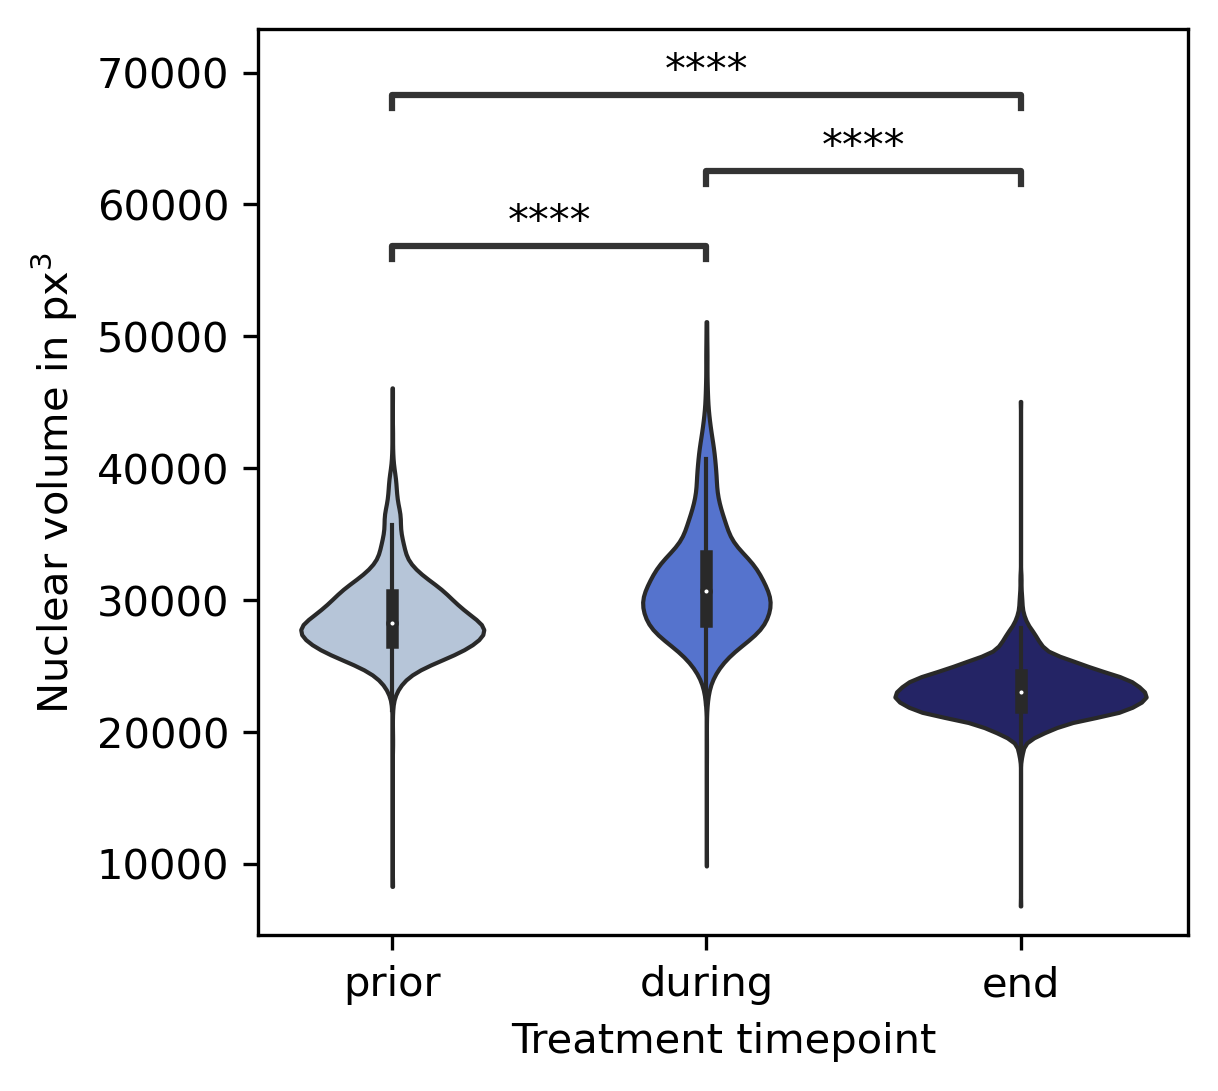

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.949e-279 t=-3.821e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=9.849e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=5.310e+01


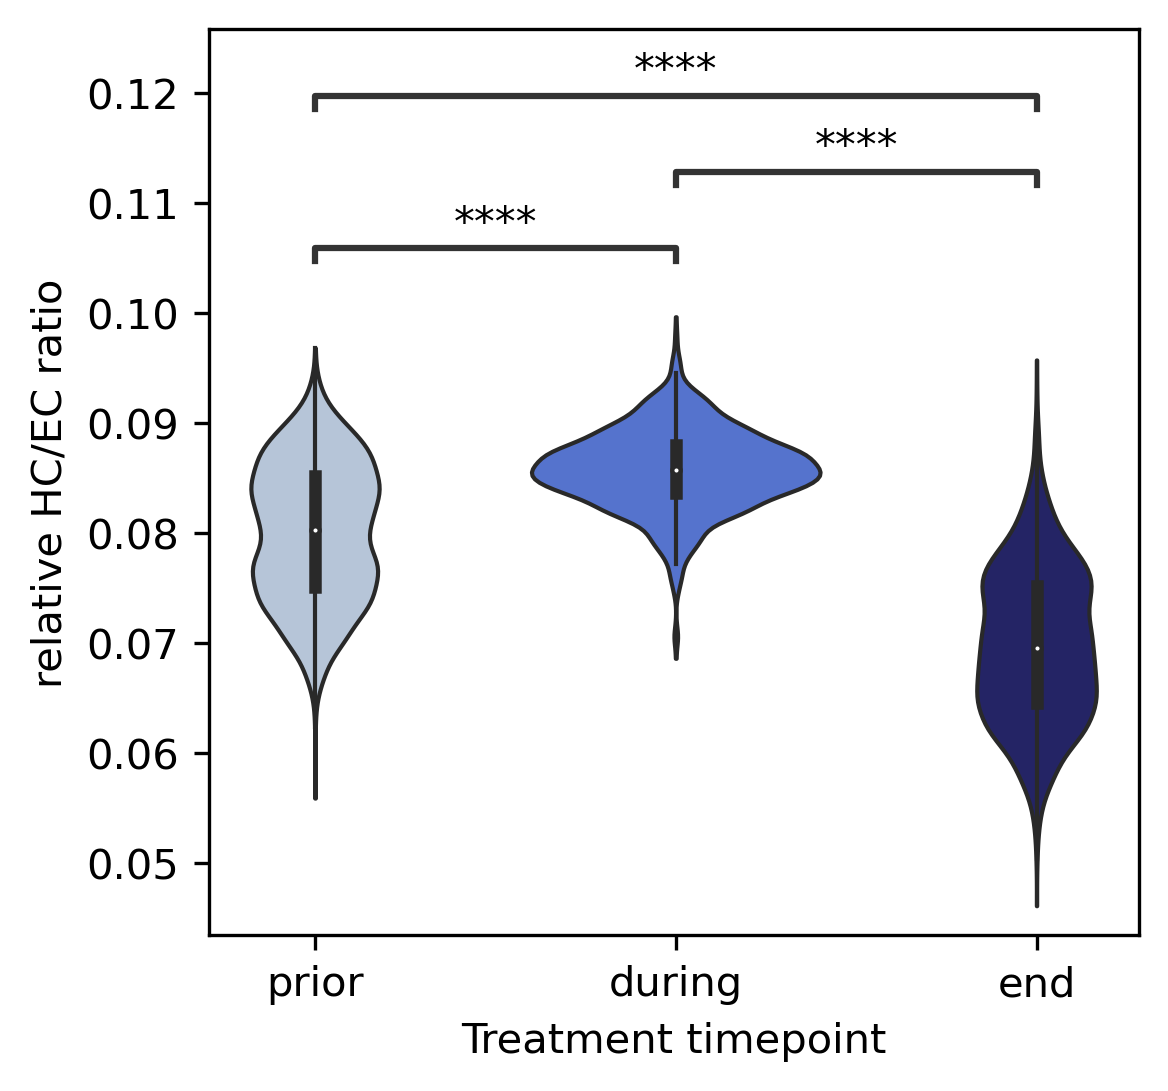

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.627e-69 t=-1.791e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.707e-145 t=2.653e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:8.523e-13 t=7.172e+00


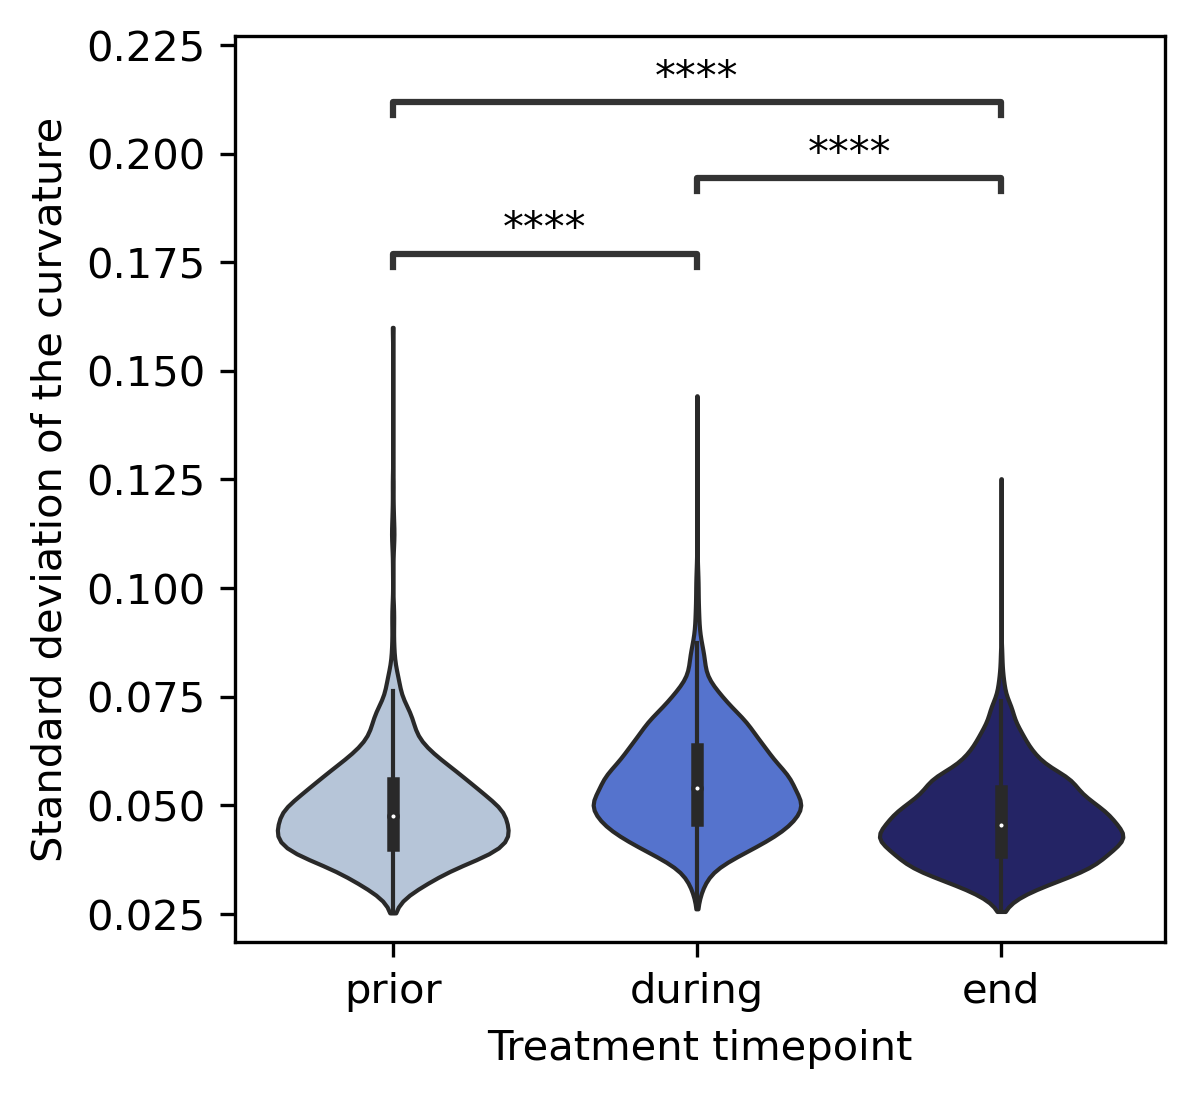

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.140e-12 t=-7.132e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.891e-06 t=-4.684e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.611e-45 t=-1.428e+01


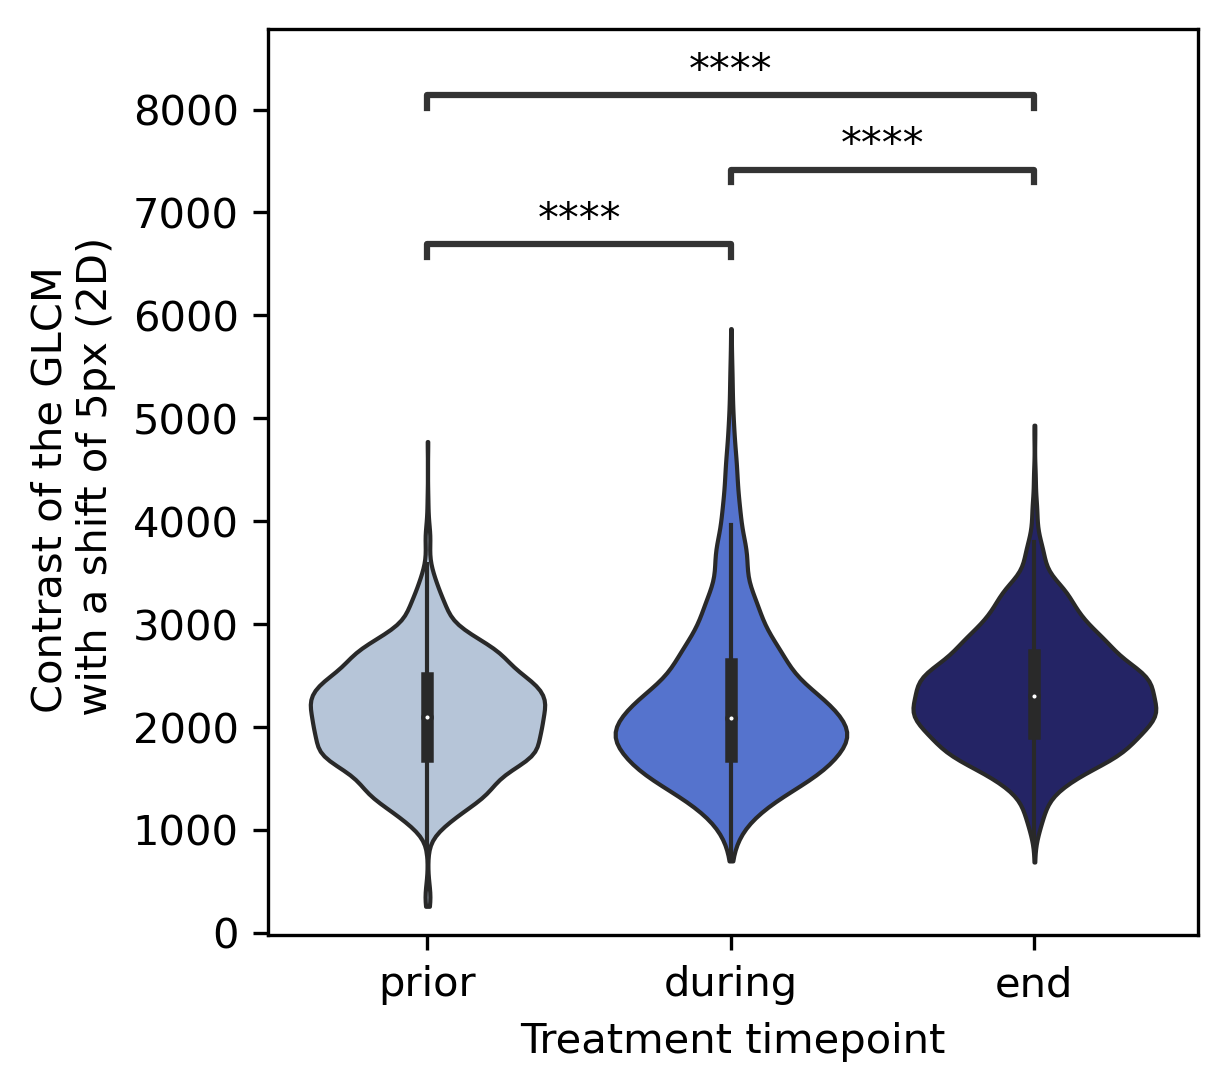

<IPython.core.display.Javascript object>

In [38]:
markers = [
    "volume",
    "hetero_to_euchromatin_volume_ratio",
    "std_curvature",
    "glcm_contrast_5px",
]
marker_labels = [
    r"Nuclear volume in px$^3$",
    "relative HC/EC ratio",
    "Standard deviation of the curvature",
    "Contrast of the GLCM \n with a shift of 5px (2D)",
]
plot_timepoint_markers_dist(
    data, markers, marker_labels, cut=0, palette=color_palette, figsize=[4, 4]
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.962e-114 t=-2.336e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=8.495e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=7.398e+01


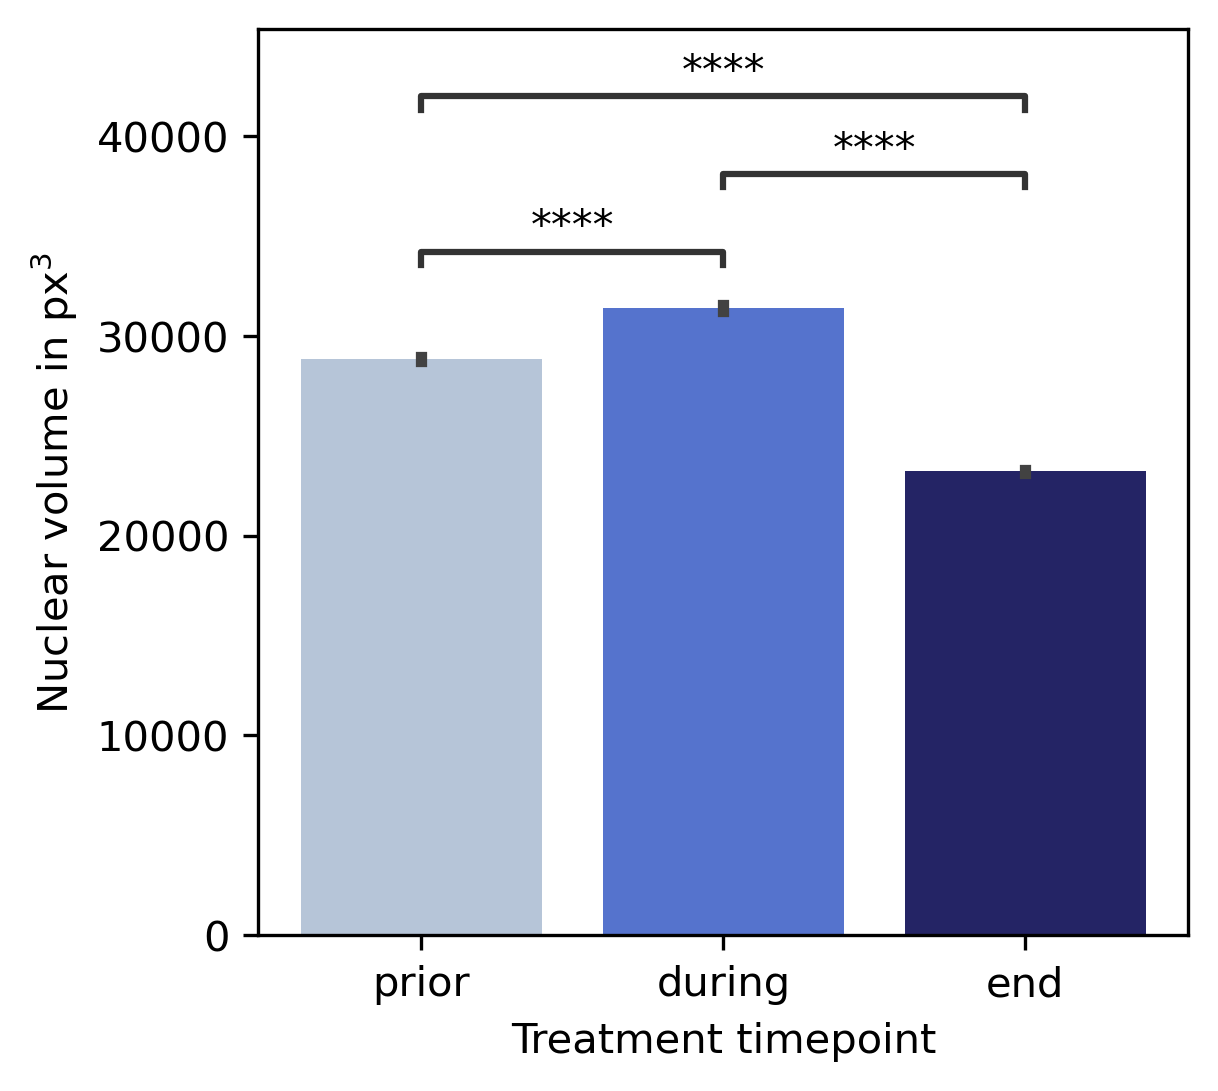

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.949e-279 t=-3.821e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=9.849e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=5.310e+01


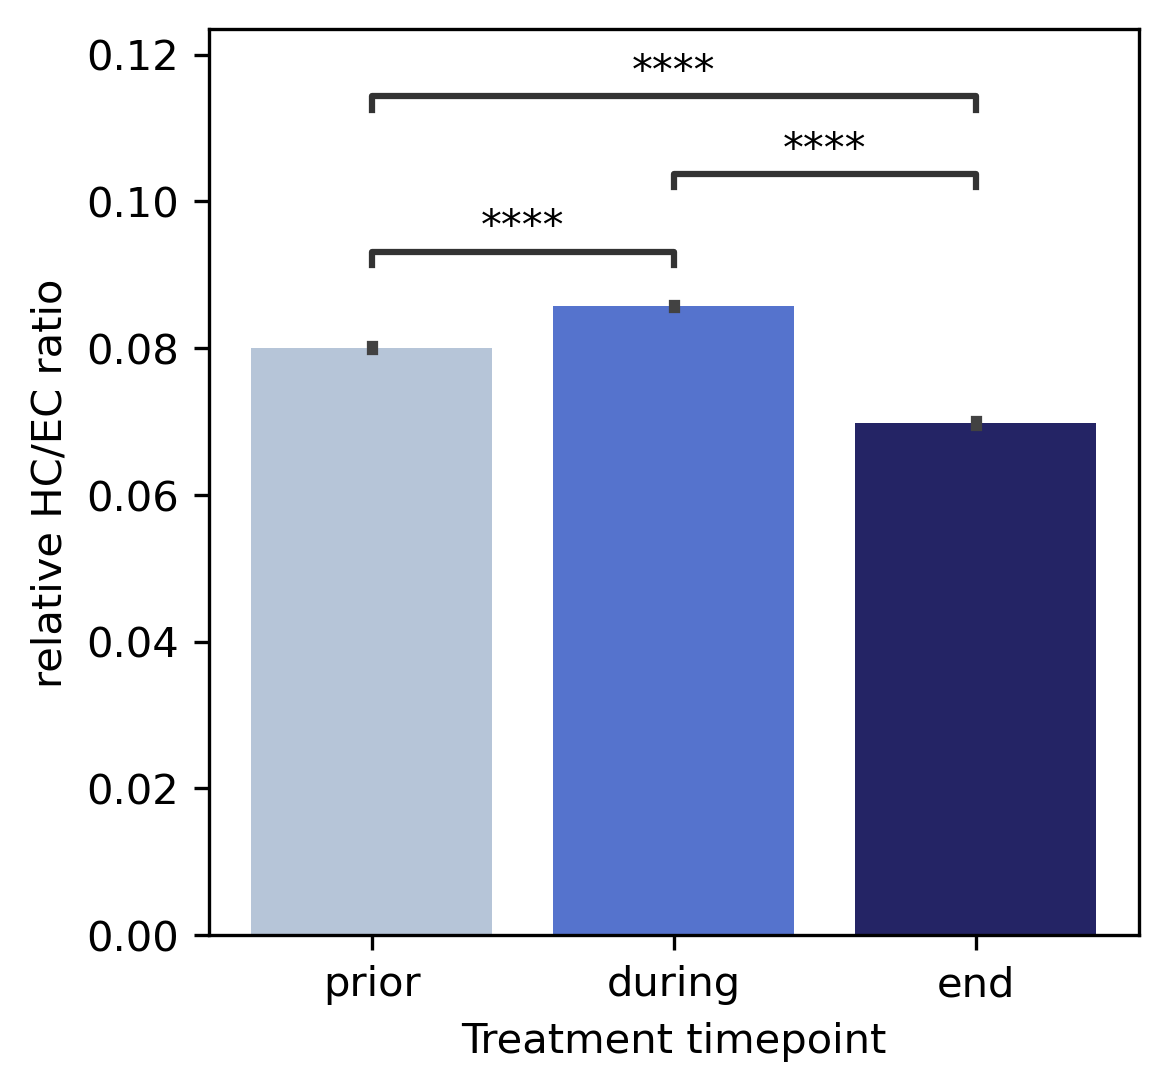

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.627e-69 t=-1.791e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.707e-145 t=2.653e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:8.523e-13 t=7.172e+00


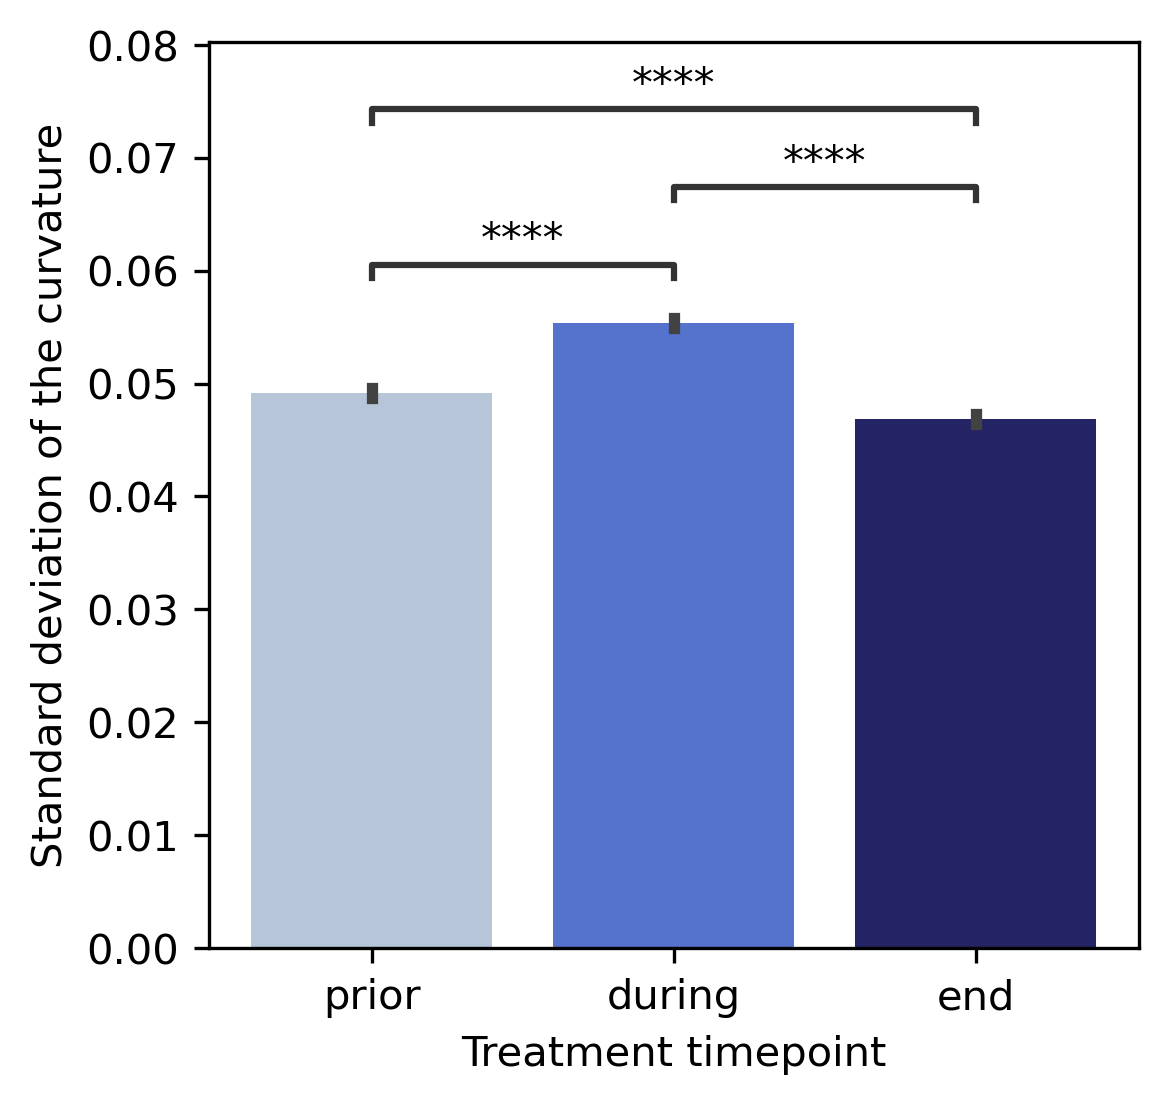

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.140e-12 t=-7.132e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.891e-06 t=-4.684e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.611e-45 t=-1.428e+01


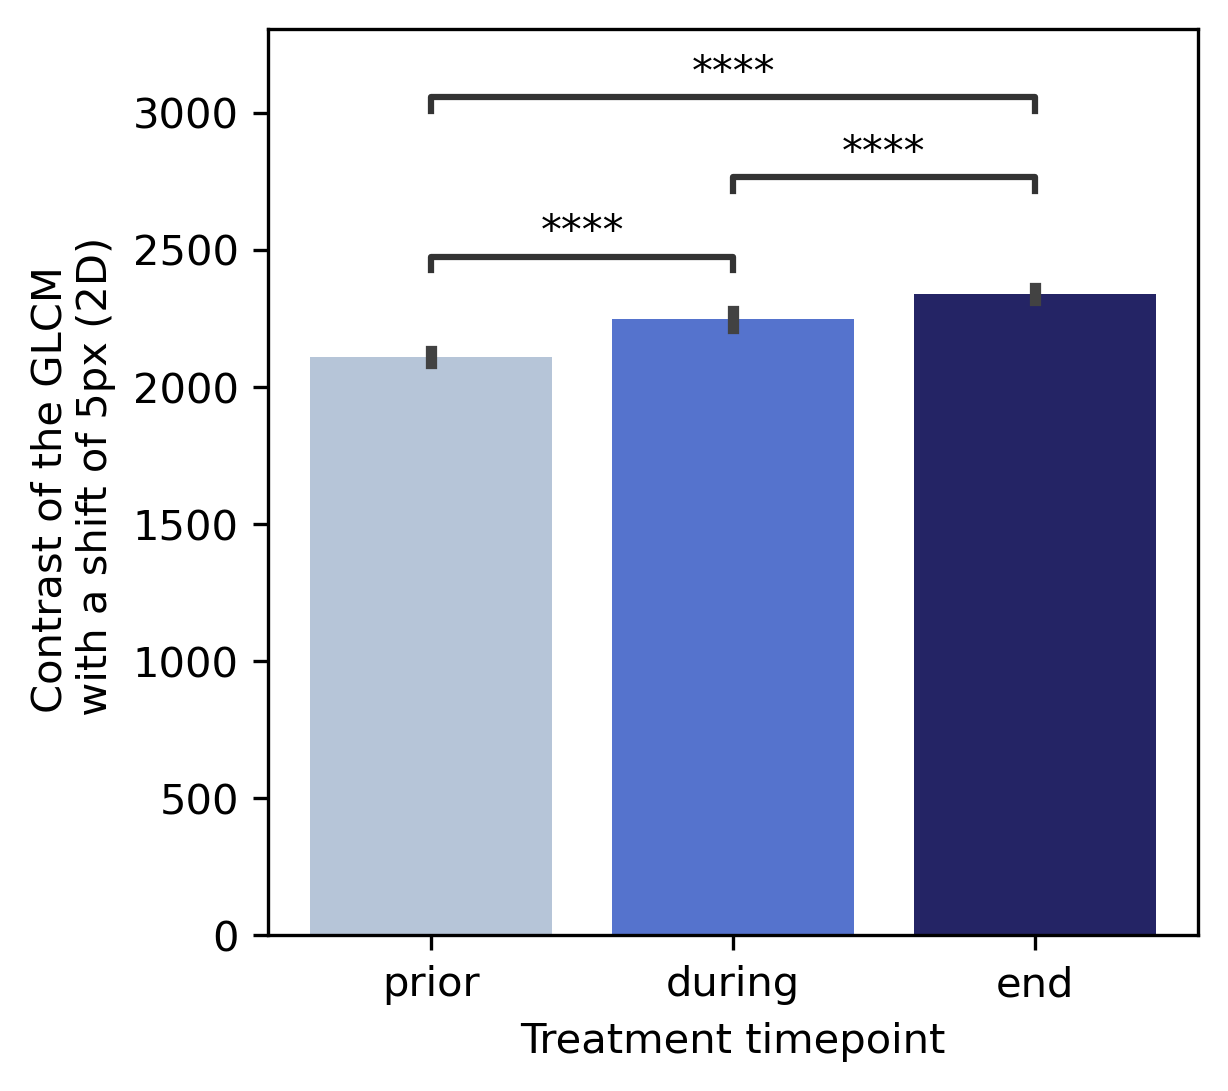

<IPython.core.display.Javascript object>

In [39]:
plot_timepoint_markers_dist(
    data, markers, marker_labels, cut=0, plot_type="bar", palette=color_palette
)

---

### 3d. Proteomic differences of PBMCs in cancer

Finally, we also assess the proteomic differences between the different treatment timepoint populations. To this end, we plot the relative Lamin and gH2AX expression measured by the sum of the intensities of the corresponding imaging channels normalized by the nuclear volume. Additionally, we plot the number of identified gH2AX foci which are computed as the local maxima peaks found in the corresponding channel images.

Note that those features are only available for the first data set that was stained for those proteins.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.050e-40 t=-1.336e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:9.694e-04 t=-3.301e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.376e-182 t=-3.004e+01


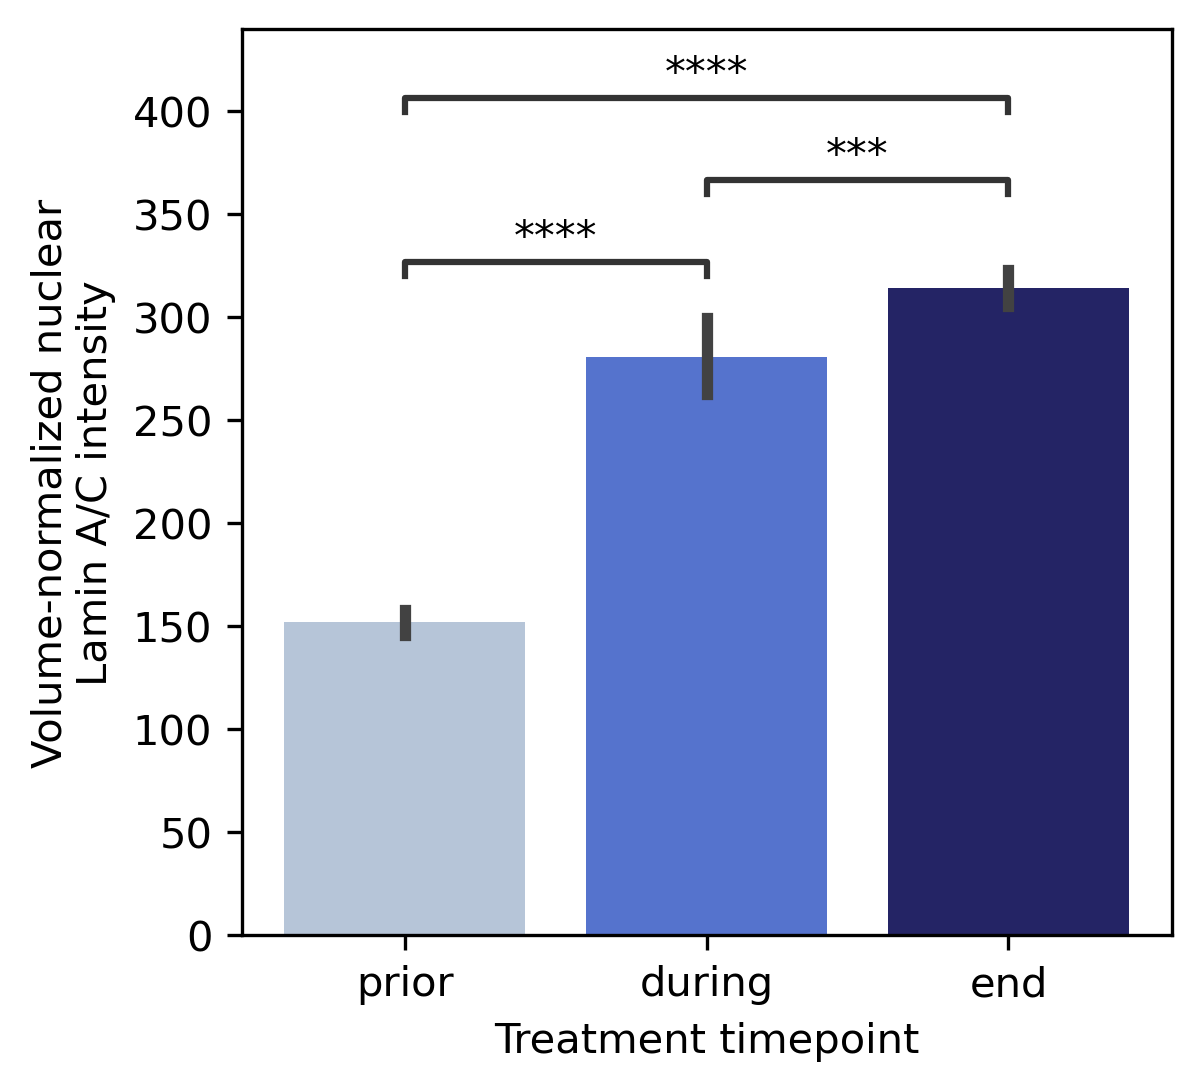

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.413e-09 t=5.879e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-8.941e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-8.154e+01


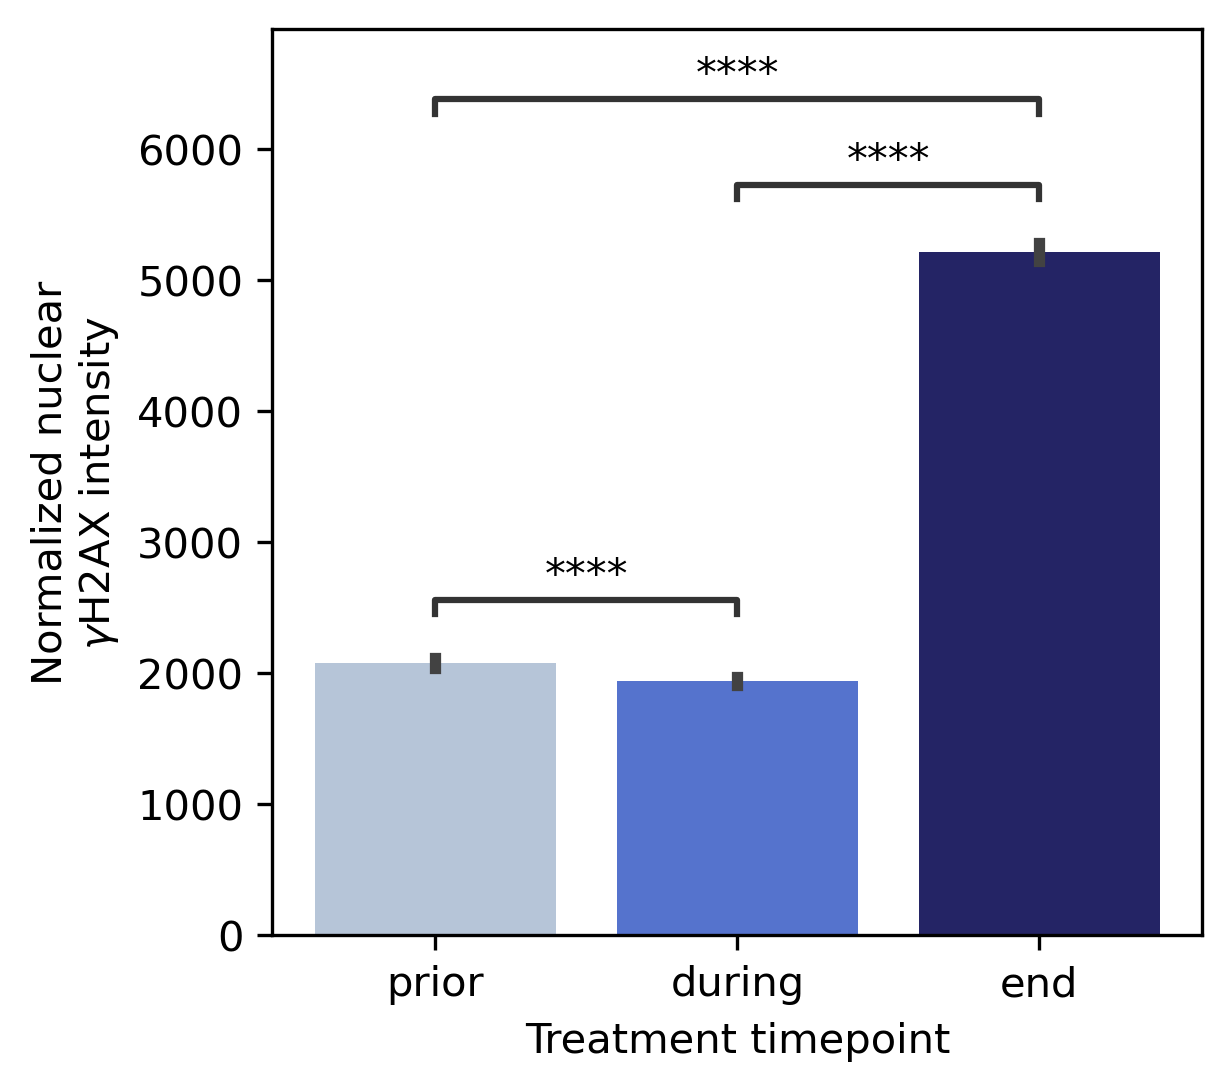

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.152e-21 t=-9.609e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:5.790e-176 t=2.950e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.893e-84 t=1.984e+01


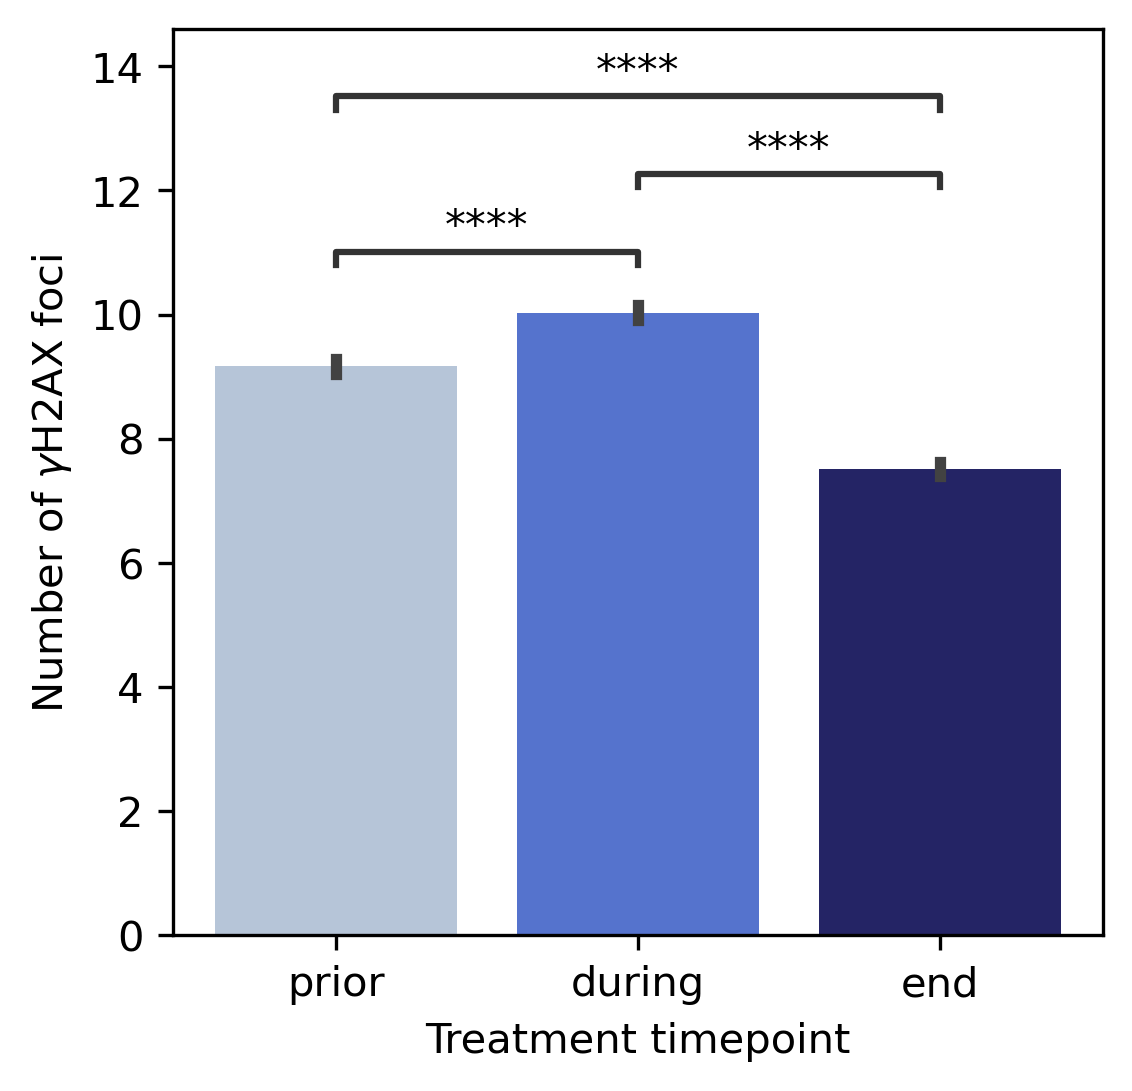

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.593e-36 t=-1.266e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=4.248e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.591e-166 t=2.856e+01


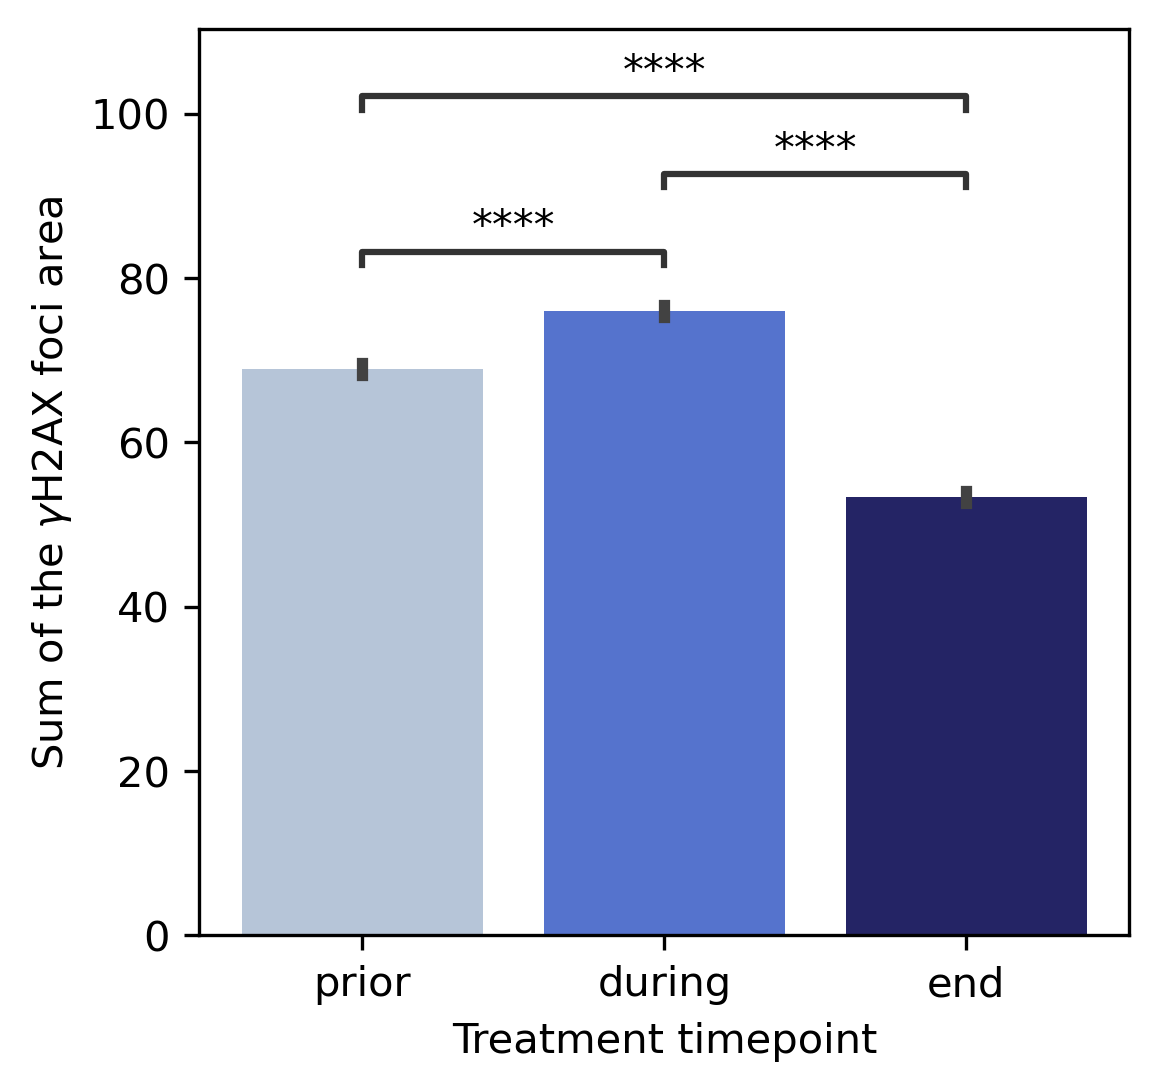

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.828e-01 t=-8.728e-01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.115e-15 t=7.961e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:9.880e-11 t=6.483e+00


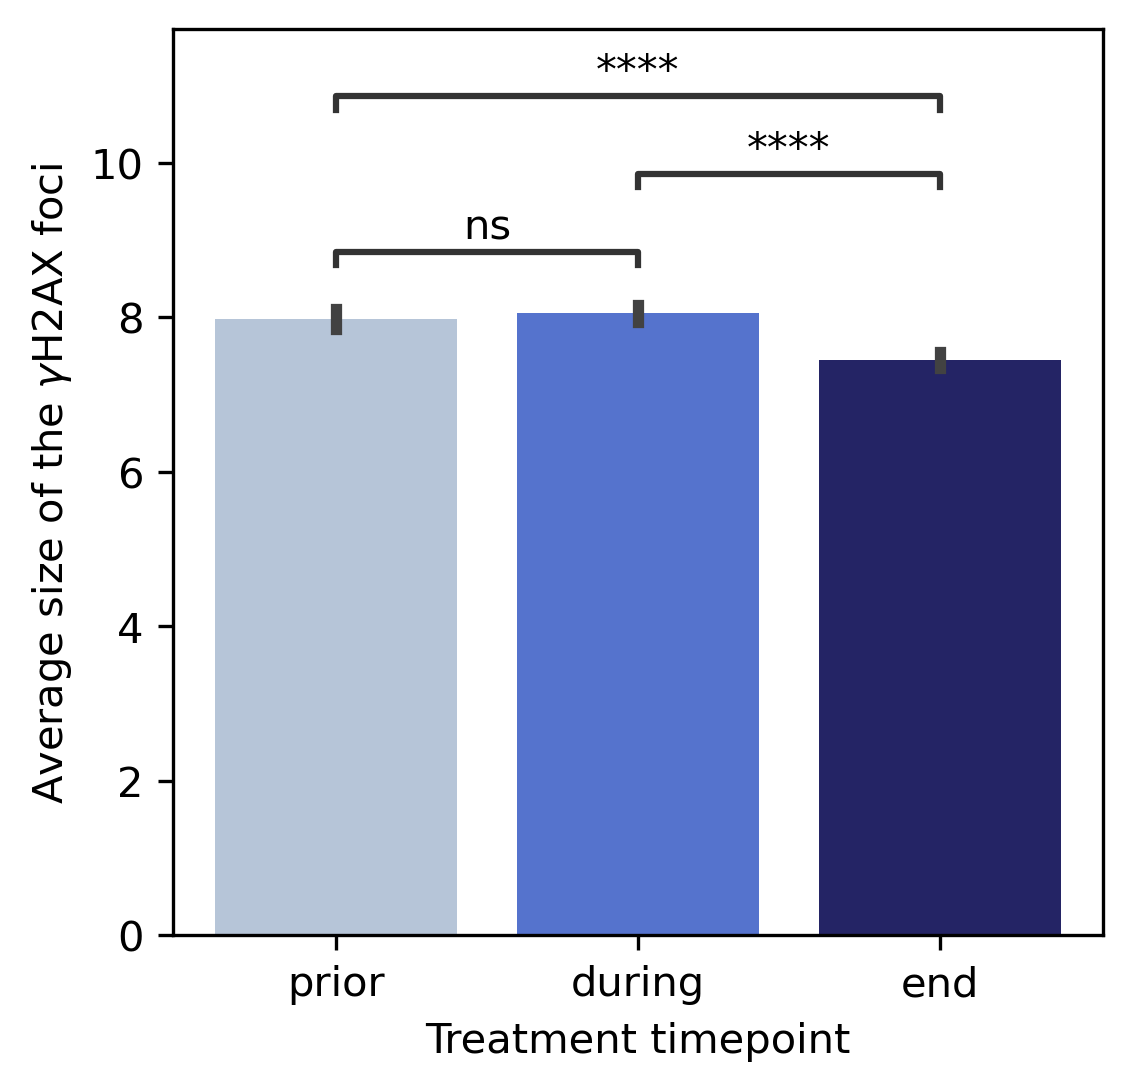

<IPython.core.display.Javascript object>

In [40]:
markers = [
    "rel_lamin_3d_int",
    "rel_gh2ax_3d_int",
    "gh2ax_foci_count",
    "gh2ax_sum_foci_area",
    "gh2ax_avg_foci_area",
]
marker_labels = [
    "Volume-normalized nuclear\nLamin A/C intensity",
    "Normalized nuclear\n" r"$\gamma$H2AX intensity",
    r"Number of $\gamma$H2AX foci",
    r"Sum of the $\gamma$H2AX foci area",
    r"Average size of the $\gamma$H2AX foci",
]
plot_timepoint_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=0,
    plot_type="bar",
    palette=color_palette,
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:5.050e-40 t=-1.336e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:9.694e-04 t=-3.301e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.376e-182 t=-3.004e+01


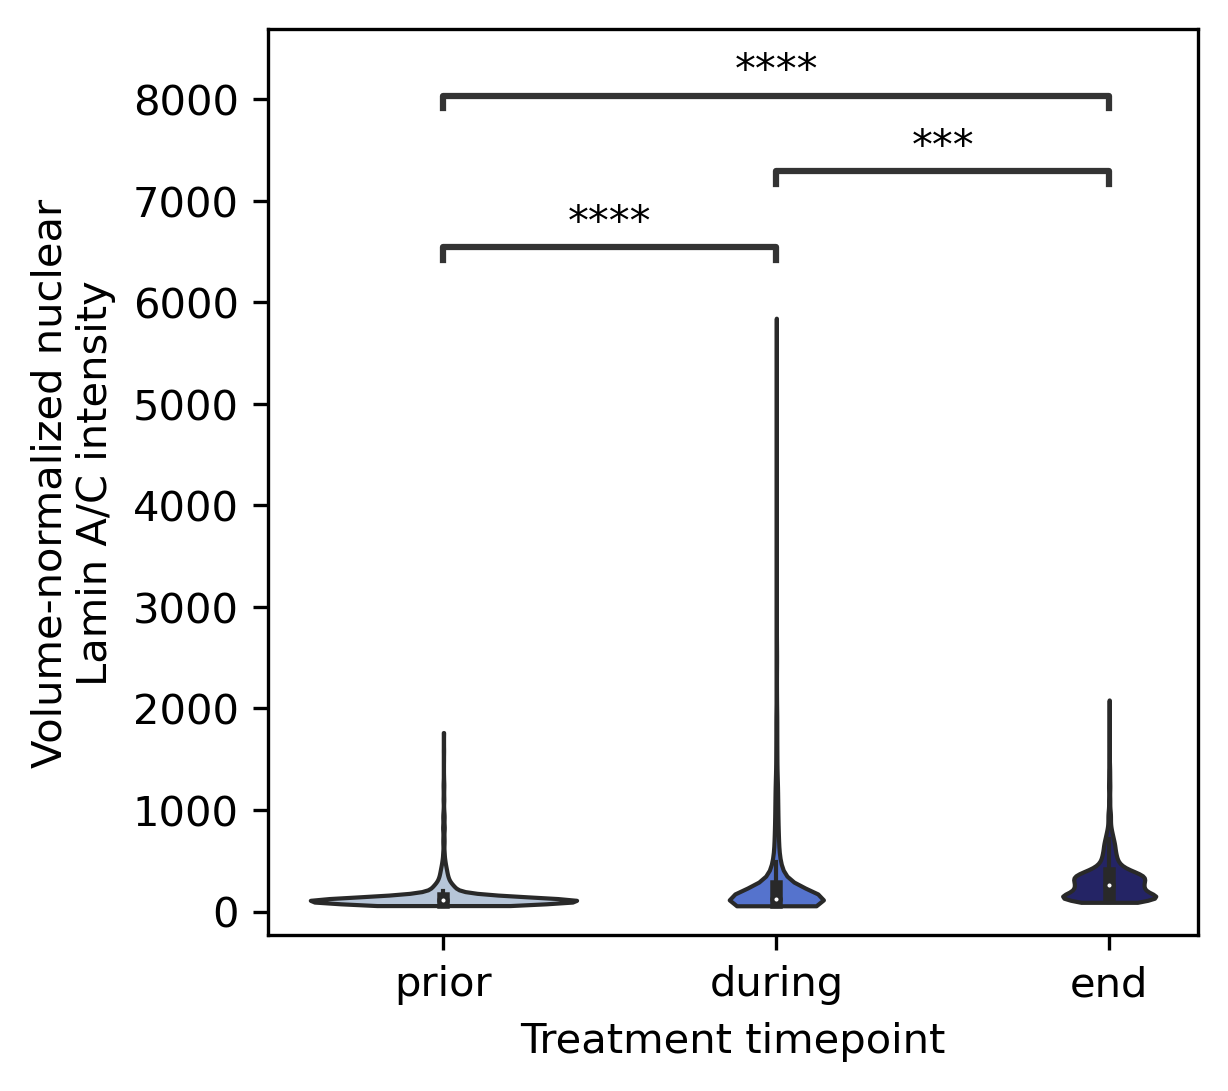

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:4.413e-09 t=5.879e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-8.941e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=-8.154e+01


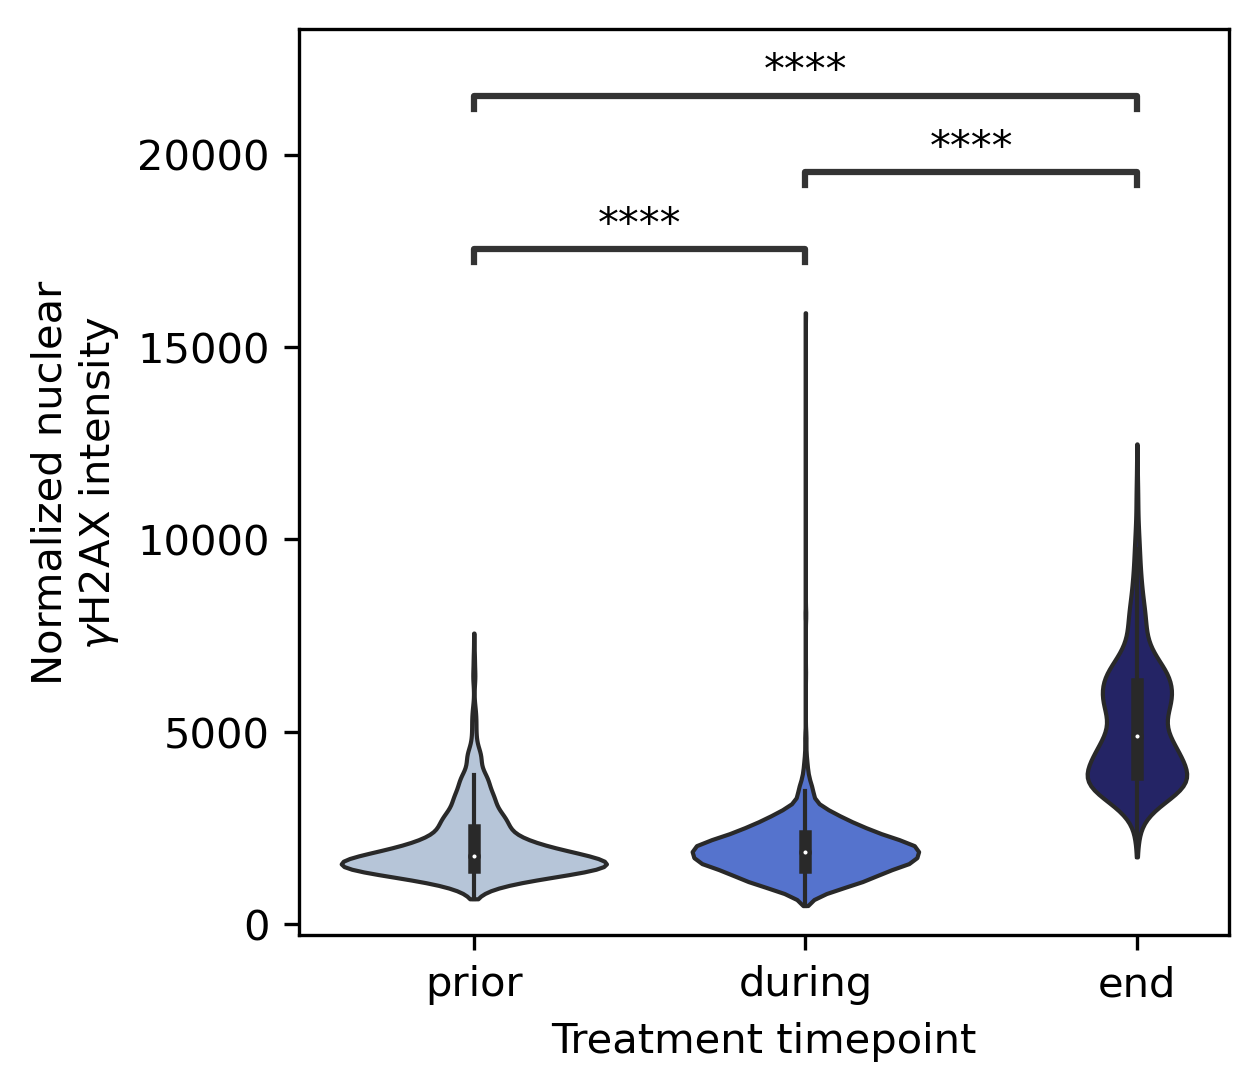

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:1.152e-21 t=-9.609e+00
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:5.790e-176 t=2.950e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.893e-84 t=1.984e+01


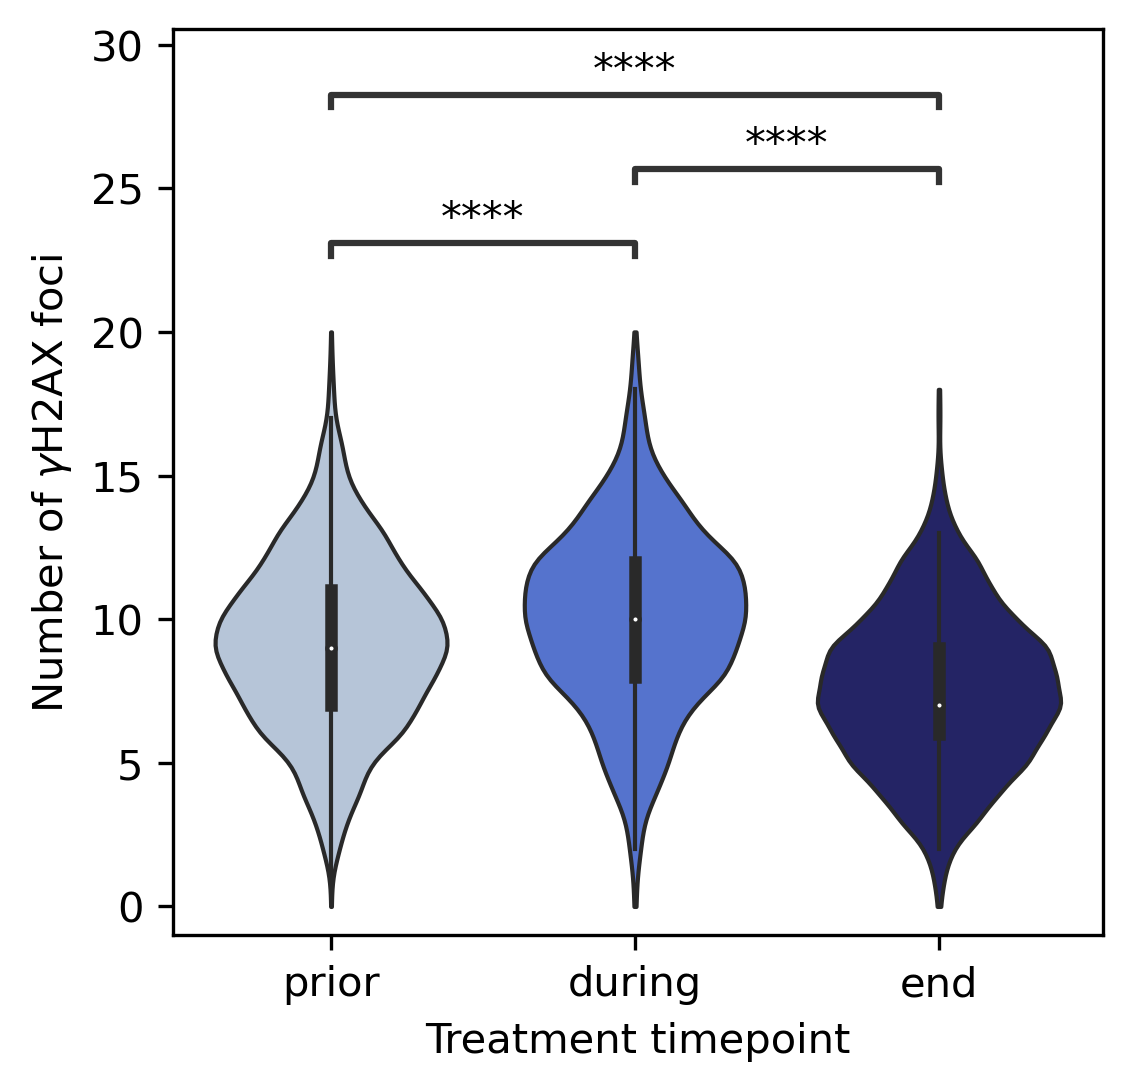

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.593e-36 t=-1.266e+01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:0.000e+00 t=4.248e+01
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:7.591e-166 t=2.856e+01


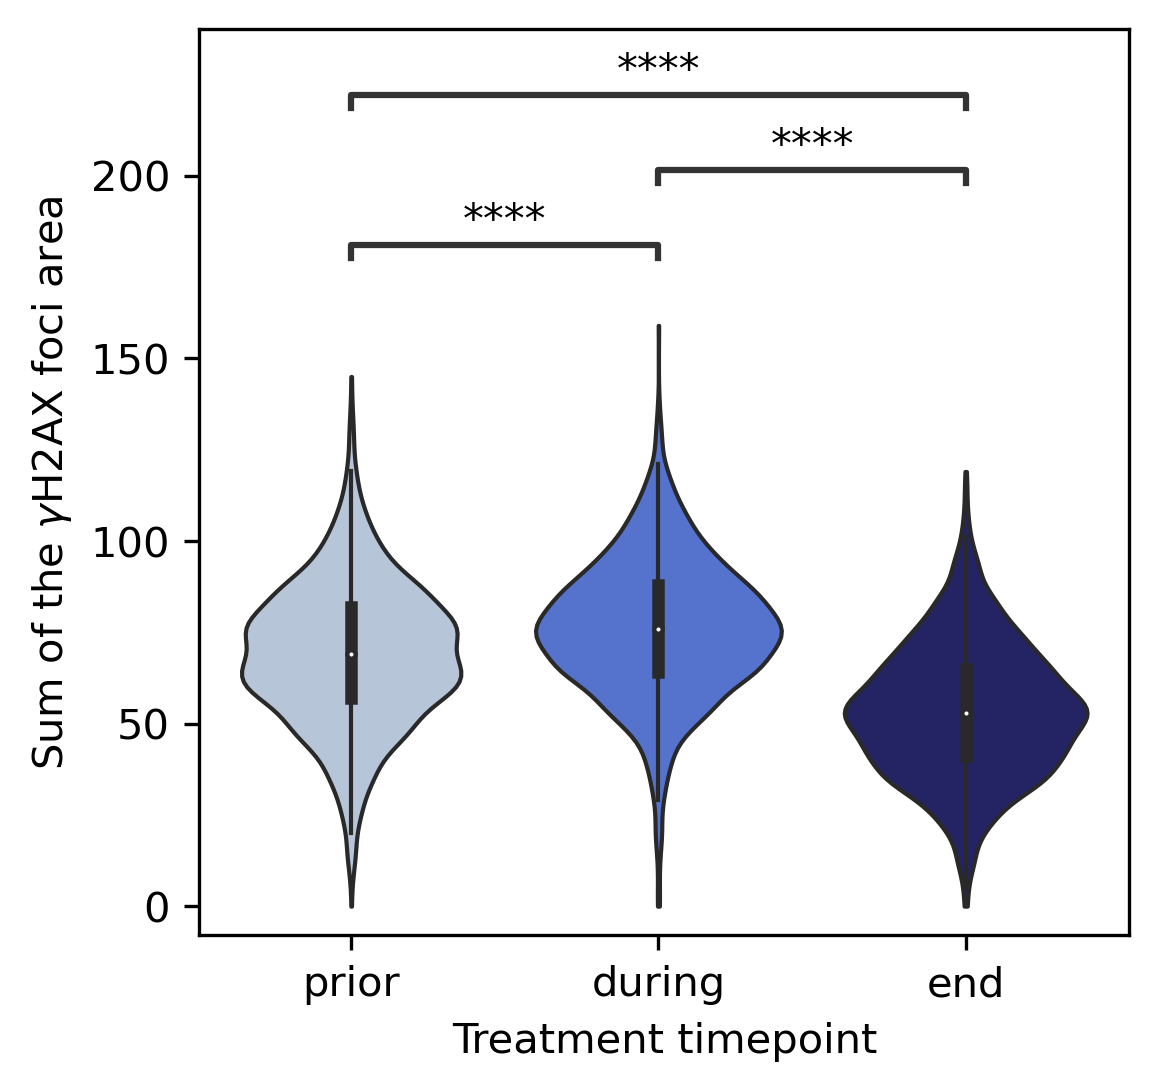

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

prior vs. during: t-test independent samples with Benjamini-Hochberg correction, P_val:3.828e-01 t=-8.728e-01
during vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:2.115e-15 t=7.961e+00
prior vs. end: t-test independent samples with Benjamini-Hochberg correction, P_val:9.880e-11 t=6.483e+00


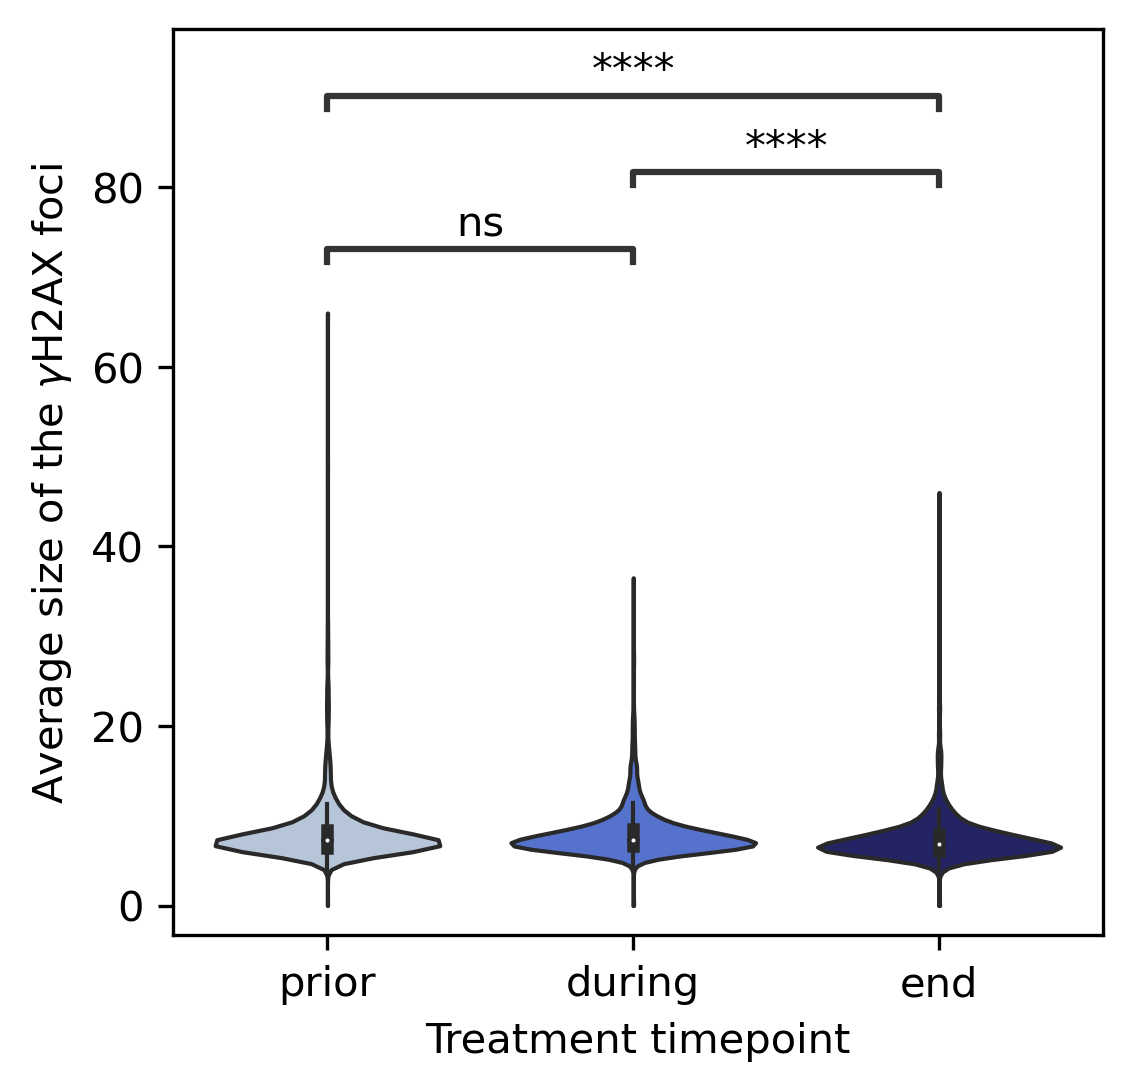

<IPython.core.display.Javascript object>

In [41]:
markers = [
    "rel_lamin_3d_int",
    "rel_gh2ax_3d_int",
    "gh2ax_foci_count",
    "gh2ax_sum_foci_area",
    "gh2ax_avg_foci_area",
]
marker_labels = [
    "Volume-normalized nuclear\nLamin A/C intensity",
    "Normalized nuclear\n" r"$\gamma$H2AX intensity",
    r"Number of $\gamma$H2AX foci",
    r"Sum of the $\gamma$H2AX foci area",
    r"Average size of the $\gamma$H2AX foci",
]
plot_timepoint_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=0,
    plot_type="violin",
    palette=color_palette,
)

---

## 4. Supplemental